# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [35]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [36]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [37]:
# we are forming a dataset with 100000 points
filtered_data=filtered_data.sample(n=100000, random_state=1)

In [38]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [39]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [40]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [41]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [42]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [43]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [44]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(86847, 10)

In [45]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.847

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [46]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [47]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [48]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(86846, 10)


1    73352
0    13494
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [49]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!
I paid way more for this than the current sale price at my local pet store ($26).  My bull terrier puppy had surgery yesterday and we were struggling to find something to turn his attention away from the stitches.  I put treats through the other side and only put one of the treat balls on the one end, saving the second for later.  He did manage to finally dislodge the treat, but even eating that took longer than his Booda Bimples.  So overall I'm very happy.  After he finished the treat on the outside, he had to find a way to get the other treats on the inside.  He's a 50# bull terrier

In [50]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


In [51]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books & songs when I did my  student teaching for preschoolers & turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &  2.  The tradition lives on!
I paid way more for this than the current sale price at my local pet store ($26).  My bull terrier puppy had surgery yesterday and we were struggling to find something to turn his attention away from the stitches.  I put treats through the other side and only put one of the treat balls on the one end, saving the second for later.  He did manage to finally dislodge the treat, but even eating that took longer than his Booda Bimples.  So overall I'm very happy.  After he finished the treat on the outside, he had to find a way to get the other treats on the inside.  He's a 50# bull terrier puppy, and 

In [52]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [53]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Received this as a holiday gift, if you are in love with rum you should like this cake. It is nice and moist and has a pungent aroma of rum. It is made in the Cayman Islands. My dog was at first, slightly repelled by the smell but now it is following me around!


In [54]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children  &amp;    The tradition lives on!


In [55]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Received this as a holiday gift if you are in love with rum you should like this cake It is nice and moist and has a pungent aroma of rum It is made in the Cayman Islands My dog was at first slightly repelled by the smell but now it is following me around 


In [56]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [57]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 86846/86846 [00:58<00:00, 1473.88it/s]


In [58]:
preprocessed_reviews[1500]

'received holiday gift love rum like cake nice moist pungent aroma rum made cayman islands dog first slightly repelled smell following around'

In [59]:
## Similartly you can do preprocessing for review summary also.

In [60]:
score=final['Score'].values

In [61]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
X_1, X_test, y_1, y_test = train_test_split(preprocessed_reviews, score, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)

# [4] Featurization

## [4.1] BAG OF WORDS

In [62]:
count_vect = CountVectorizer() 
bag_counts = count_vect.fit_transform(X_tr)
testvalues=count_vect.transform(X_test)
cvvalues=count_vect.transform(X_cv)

In [63]:
###Bow for kdtree
count_vect_kdtree = CountVectorizer(min_df=10, max_features=500)
#count_vect = CountVectorizer(min_df=10, max_features=500) 
bag_counts_kdtree=count_vect_kdtree.fit_transform(X_tr)
testvalues_kdtree=count_vect_kdtree.transform(X_test)
cvvalues_kdtree=count_vect_kdtree.transform(X_cv)
            

In [64]:
##converting sparse matrix to dense for kdtree
bag_counts_kdtree=bag_counts_kdtree.toarray()
testvalues_kdtree=testvalues_kdtree.toarray()
cvvalues_kdtree=cvvalues_kdtree.toarray()

In [65]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    B =(C/C.sum(axis=0))
    
    
    labels = [0,1]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
   
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## [4.3] TF-IDF

In [66]:
tf_idf_vect = TfidfVectorizer()
train_tfidf_text = tf_idf_vect.fit_transform(X_tr)
cv_tfidf_text=tf_idf_vect.transform(X_cv)
test_tfidf_text=tf_idf_vect.transform(X_test)

In [67]:
#TFIDF vectors for kdtree
tf_idf_vect_kdtree = TfidfVectorizer(min_df=10, max_features=500)
 
train_tfidf_text_kdtree = tf_idf_vect_kdtree.fit_transform(X_tr)
cv_tfidf_text_kdtree=tf_idf_vect_kdtree.transform(X_cv)
test_tfidf_text_kdtree=tf_idf_vect_kdtree.transform(X_test)

In [68]:
#Converting sparse tfidf matrix into dense
train_tfidf_text_kdtree =train_tfidf_text_kdtree.toarray()
cv_tfidf_text_kdtree=cv_tfidf_text_kdtree.toarray()
test_tfidf_text_kdtree=test_tfidf_text_kdtree.toarray()

## [4.4] Word2Vec

In [69]:
# Train your own Word2Vec model using your own text corpus for RBF kernal train data
i=0
list_of_sentance=[]
list_of_sentance_cv=[]
list_of_sentance_test=[]
for sentance in X_tr:
    list_of_sentance.append(sentance.split())
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())


In [70]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8457112312316895), ('wonderful', 0.804780900478363), ('good', 0.804115891456604), ('fantastic', 0.7910528182983398), ('excellent', 0.7787269353866577), ('perfect', 0.7346395254135132), ('amazing', 0.7318770885467529), ('terrific', 0.7262497544288635), ('nice', 0.6721346974372864), ('fabulous', 0.6503192186355591)]
[('best', 0.7597724795341492), ('tastiest', 0.7129868268966675), ('closest', 0.688643217086792), ('weakest', 0.6624863743782043), ('greatest', 0.6585644483566284), ('smoothest', 0.652765691280365), ('coolest', 0.6440487504005432), ('disgusting', 0.6264272332191467), ('awful', 0.6158839464187622), ('superior', 0.5963394641876221)]


In [71]:
w2v_words = list(w2v_model.wv.vocab) ##for linear kernal
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12835
sample words  ['received', 'first', 'bag', 'cameron', 'intense', 'french', 'roast', 'immediately', 'brewed', 'pot', 'coffee', 'great', 'cup', 'deep', 'yet', 'lively', 'tongue', 'smooth', 'not', 'bitter', 'wonderful', 'smokey', 'finish', 'pleasantly', 'surprised', 'find', 'indonesian', 'quality', 'light', 'depth', 'vibrant', 'non', 'comment', 'aroma', 'negligible', 'going', 'try', 'like', 'wind', 'water', 'better', 'twice', 'price', 'drink', 'lot', 'house', 'especially', 'since', 'parents', 'bought']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [72]:
# average Word2Vec for linear
# compute average word2vec of each review for linear svm train data
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 42554/42554 [02:01<00:00, 348.80it/s]

42554
50


In [73]:
# average Word2Vec for linear
# compute average word2vec of each review for linear kernal cv data
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 18238/18238 [00:52<00:00, 344.44it/s]

18238
50


In [74]:
# average Word2Vec for linear
# compute average word2vec of each review for linear kernal test data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 26054/26054 [01:14<00:00, 351.96it/s]

26054
50


#### [4.4.1.2] TFIDF weighted W2v

In [75]:
# Tfidf word to vec model training for linear svm
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [76]:
# TF-IDF weighted Word2Vec training for  linear keranl train data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

100%|██████████| 42554/42554 [20:56<00:00, 33.86it/s]


In [77]:
# TF-IDF weighted Word2Vec  training for linear keranl cv data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 18238/18238 [06:51<00:00, 44.31it/s]


In [78]:
# TF-IDF weighted Word2Vec  training for linear keranl test data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 26054/26054 [09:25<00:00, 46.11it/s]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

for k = 1
for k = 3
for k = 5
for k = 7
for k = 9
for k = 11
for k = 13

The optimal alpha is . 9


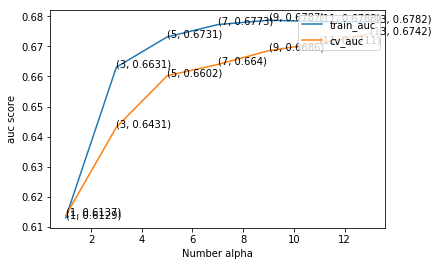

the auc score for each alpha value is :  [0.6129 0.6631 0.6731 0.6773 0.6787 0.6783 0.6782]
For values of best alpha =  9 The train auc is: 0.8358166403385319
For values of best alpha =  9 The cross validation auc is: 69.57398929642228
For values of best alpha =  9 The test  auc is: 69.26057517553272


In [77]:
# Please write all the code with proper documentation
myList = list(range(0,15))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# list that hold the cv score list
cv_scores_train=[]
cv_scores_cv=[]
# performing 10-fold cross validation using brute force approach
for k in neighbors:
    print("for k =", k)
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    knn.fit(bag_counts,y_tr)
    sig_clf_bow = CalibratedClassifierCV(knn, method="sigmoid")
    sig_clf_bow.fit(bag_counts, y_tr)
    scores_train = cross_val_score(sig_clf_bow, bag_counts, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf_bow, cvvalues, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
optimal_k = neighbors[cv_scores_train.index(max(cv_scores_train))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(neighbors, cv_scores_train,label="train_auc")
plt.plot(neighbors, cv_scores_cv,label="cv_auc")


for xy in zip(neighbors, np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(neighbors, np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
best_k = optimal_k
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
knn.fit(bag_counts,y_tr)
sig_clf_bow = CalibratedClassifierCV(knn, method="sigmoid")
sig_clf_bow.fit(bag_counts, y_tr)
predict_y = sig_clf_bow.predict_proba(bag_counts)[:,1]
acc = roc_auc_score(y_tr, predict_y)
print('For values of best alpha = ', best_k, "The train auc is:",acc)
predict_y = sig_clf_bow.predict_proba(cvvalues)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_k, "The cross validation auc is:",acc)
predict_y = sig_clf_bow.predict_proba(testvalues)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_k, "The test  auc is:",acc)

# ROC curve for train and test data 

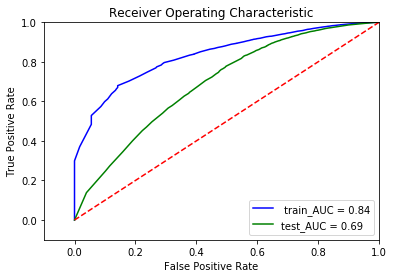

In [79]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

predict_y_train = sig_clf_bow.predict_proba(bag_counts)[:,1]
predict_y_test = sig_clf_bow.predict_proba(testvalues)[:,1]
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#  construction of confusion matrix for test data

-------------------- Confusion matrix --------------------


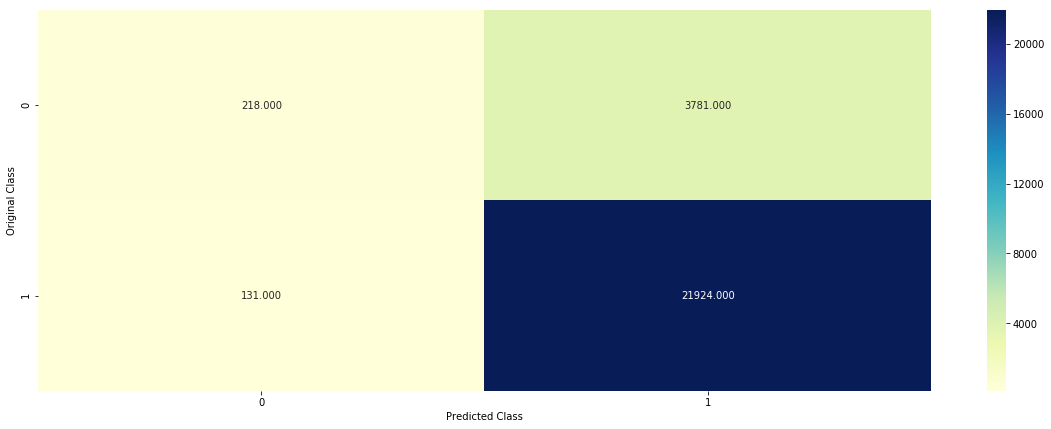

-------------------- Precision matrix (Columm Sum=1) --------------------


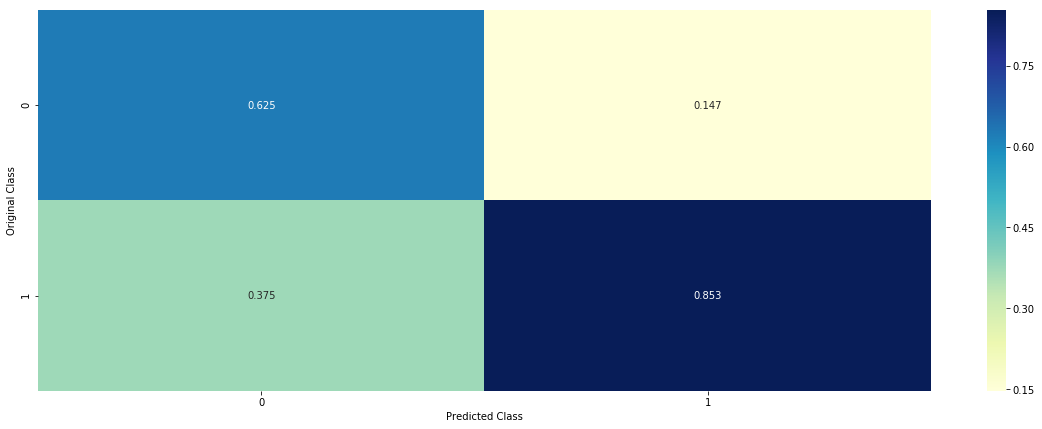

-------------------- Recall matrix (Row sum=1) --------------------


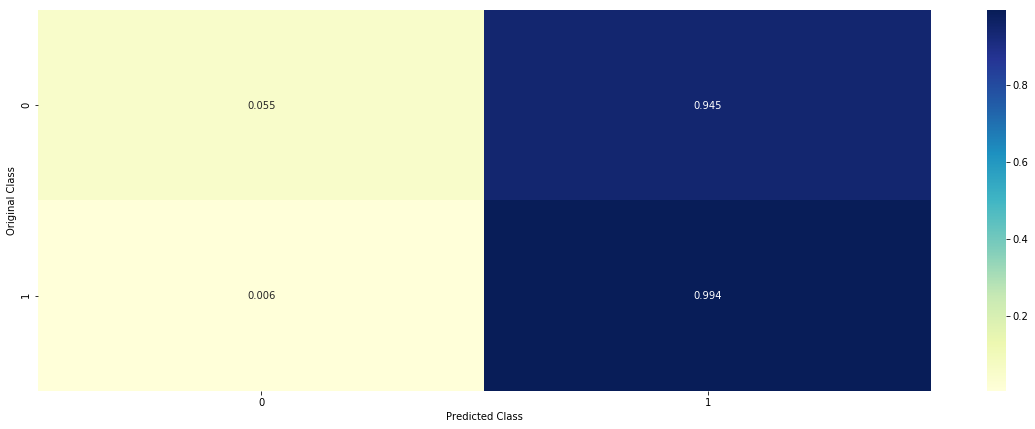

In [80]:
predict_y = sig_clf_bow.predict(testvalues)
plot_confusion_matrix(y_test, predict_y)

# confusion matrix for cv data

-------------------- Confusion matrix --------------------


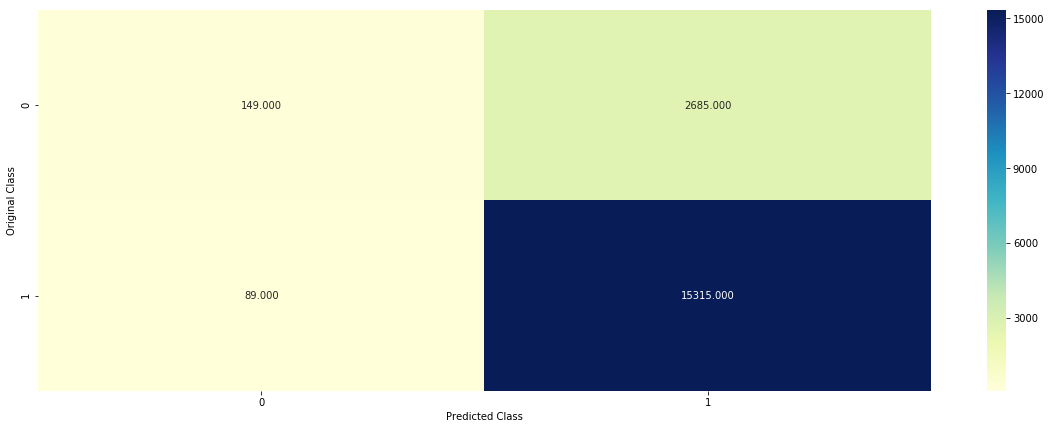

-------------------- Precision matrix (Columm Sum=1) --------------------


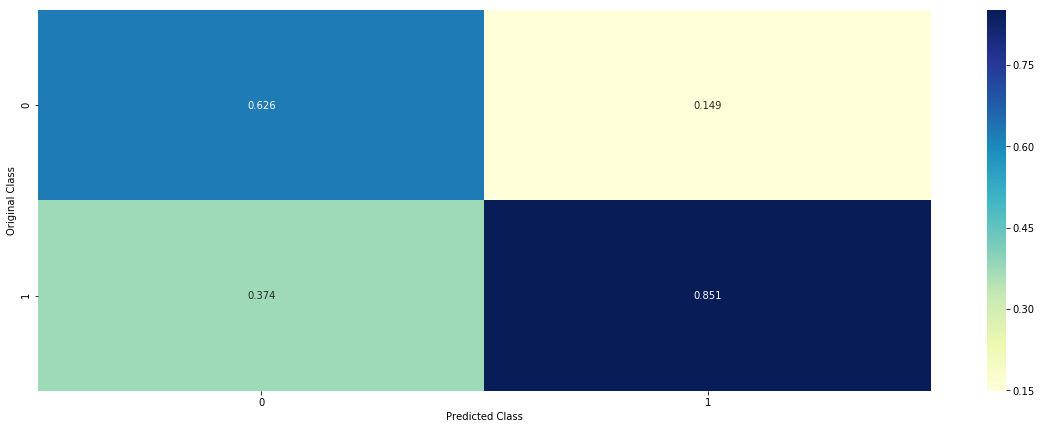

-------------------- Recall matrix (Row sum=1) --------------------


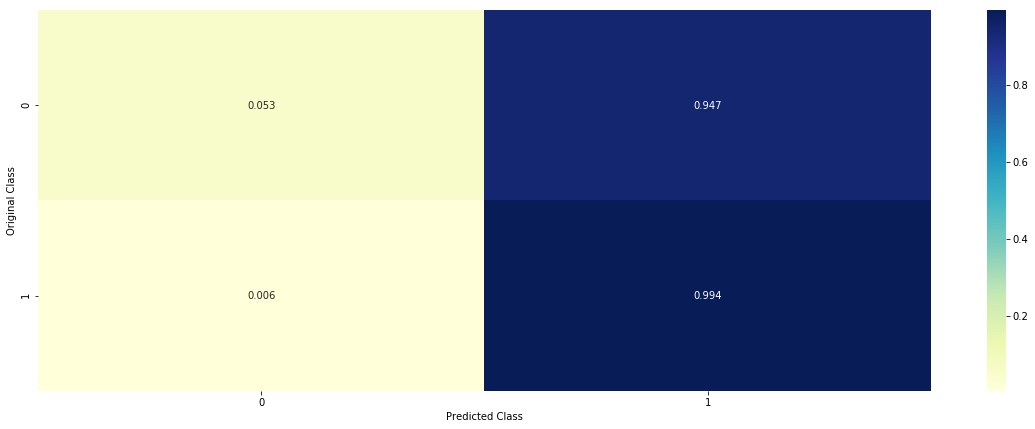

In [81]:
predict_y = sig_clf_bow.predict(cvvalues)
plot_confusion_matrix(y_cv, predict_y)

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

for k = 1
for k = 3
for k = 5
for k = 7
for k = 9
for k = 11
for k = 13

The optimal alpha is . 3


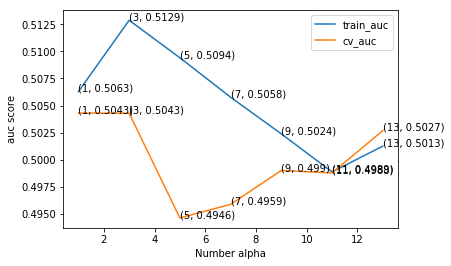

the auc score for each alpha value is :  [0.5063 0.5129 0.5094 0.5058 0.5024 0.4989 0.5013]
For values of best alpha =  3 The train auc is: 99.43531076722377
For values of best alpha =  3 The cross validation auc is: 50.93215232293549
For values of best alpha =  3 The test  auc is: 50.69323213823179


In [82]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
myList = list(range(0,15))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# list that hold the cv score list
cv_scores_train=[]
cv_scores_cv=[]
# performing 10-fold cross validation using brute force approach
for k in neighbors:
    print("for k =", k)
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    knn.fit(train_tfidf_text, y_tr)
    sig_clf_tfidf = CalibratedClassifierCV(knn, method="sigmoid")
    sig_clf_tfidf.fit(train_tfidf_text, y_tr)
    scores_train = cross_val_score(sig_clf_tfidf,train_tfidf_text, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf_tfidf, cv_tfidf_text, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
optimal_k = neighbors[cv_scores_train.index(max(cv_scores_train))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(neighbors, cv_scores_train,label="train_auc")
plt.plot(neighbors, cv_scores_cv,label="cv_auc")


for xy in zip(neighbors, np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(neighbors, np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
best_k = optimal_k
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
knn.fit(train_tfidf_text, y_tr)
sig_clf_tfidf = CalibratedClassifierCV(knn, method="sigmoid")
sig_clf_tfidf.fit(train_tfidf_text, y_tr)
predict_y = sig_clf_tfidf.predict_proba(train_tfidf_text)[:,1]
acc = roc_auc_score(y_tr, predict_y)*100
print('For values of best alpha = ', best_k, "The train auc is:",acc)
predict_y = sig_clf_tfidf.predict_proba(cv_tfidf_text)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_k, "The cross validation auc is:",acc)
predict_y = sig_clf_tfidf.predict_proba(test_tfidf_text)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_k, "The test  auc is:",acc)

# ROC curve for train and test data 

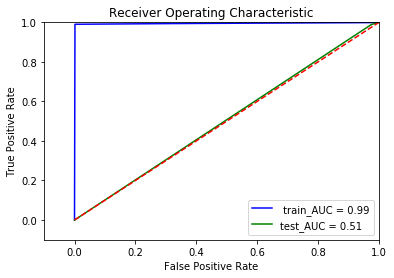

In [83]:
predict_y_train = sig_clf_tfidf.predict_proba(train_tfidf_text)[:,1]
predict_y_test = sig_clf_tfidf.predict_proba(test_tfidf_text)[:,1]
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
construction of confusion matrix for test data

-------------------- Confusion matrix --------------------


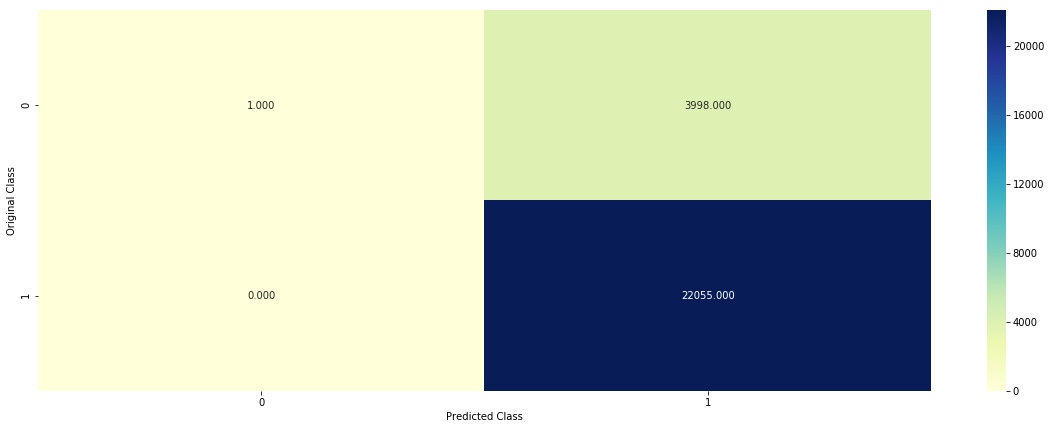

-------------------- Precision matrix (Columm Sum=1) --------------------


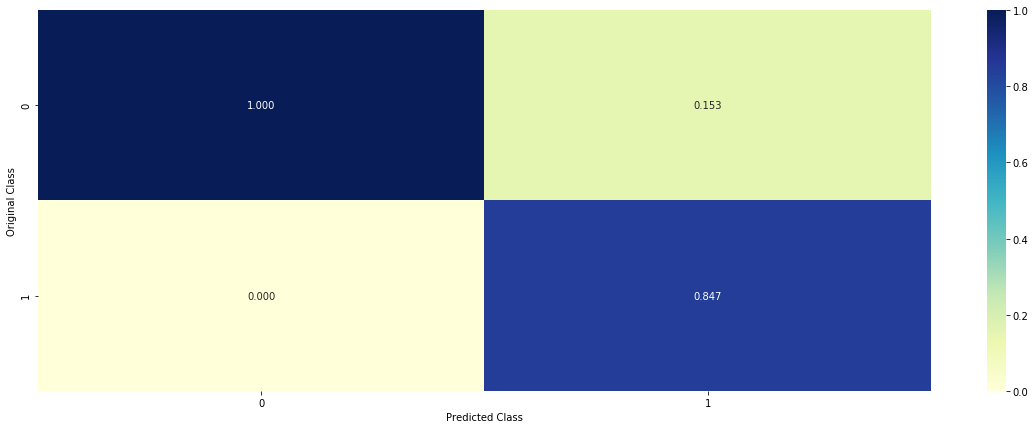

-------------------- Recall matrix (Row sum=1) --------------------


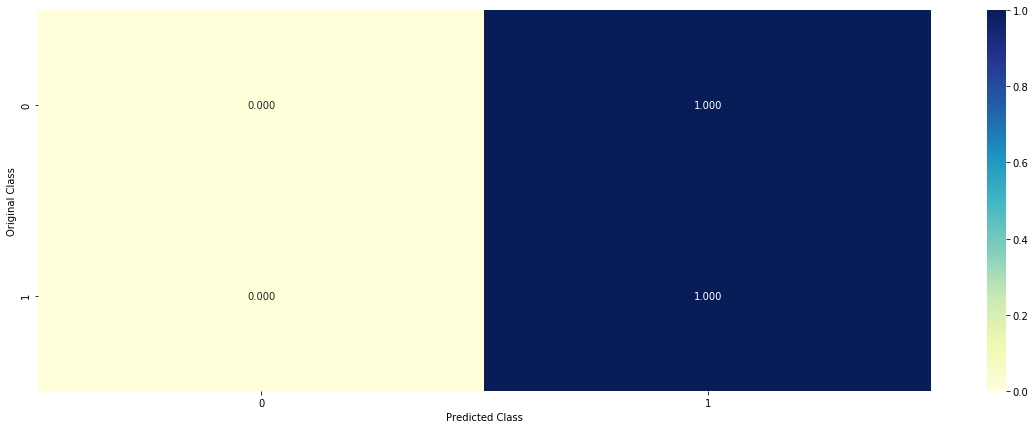

In [84]:
predict_y = sig_clf_tfidf.predict(test_tfidf_text)
plot_confusion_matrix(y_test, predict_y)

In [ ]:
confusion matrix for cv data

-------------------- Confusion matrix --------------------


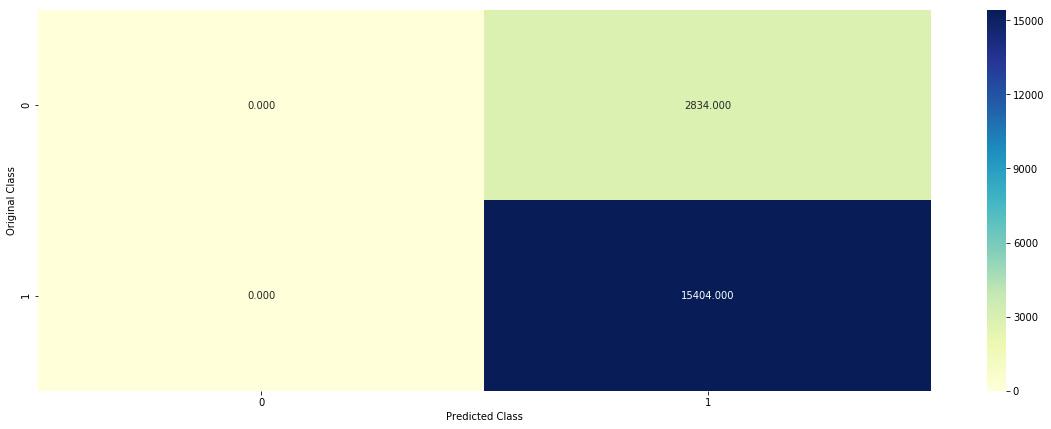

-------------------- Precision matrix (Columm Sum=1) --------------------


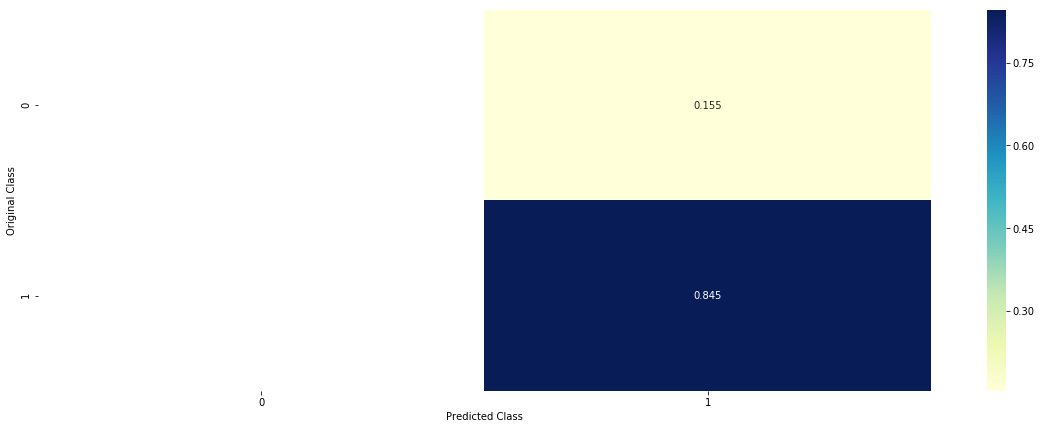

-------------------- Recall matrix (Row sum=1) --------------------


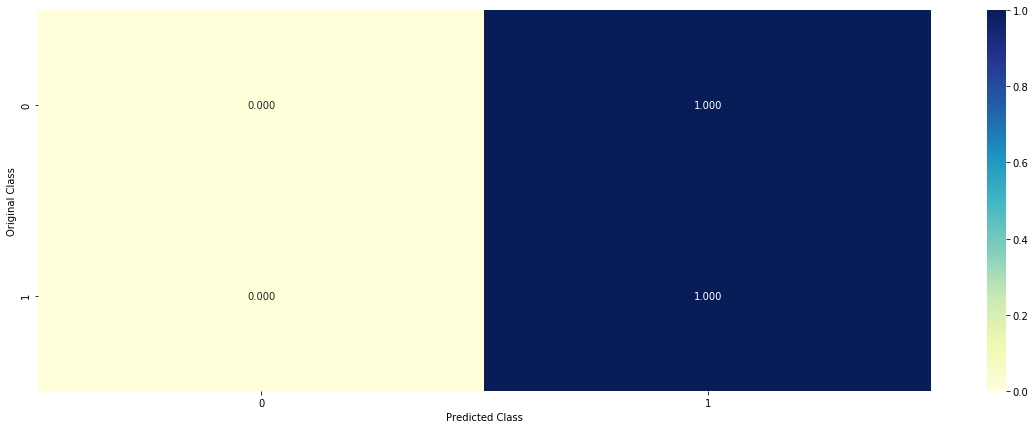

In [85]:
predict_y = sig_clf_tfidf.predict(cv_tfidf_text)
plot_confusion_matrix(y_cv, predict_y)

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

for k = 1
for k = 3
for k = 5
for k = 7
for k = 9
for k = 11
for k = 13

The optimal alpha is . 13


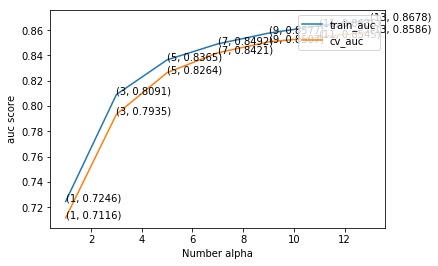

the auc score for each alpha value is :  [0.7246 0.8091 0.8365 0.8492 0.8577 0.8635 0.8678]
For values of best alpha =  13 The train auc is: 0.9125499005528506
For values of best alpha =  13 The cross validation auc is: 87.08075187648883
For values of best alpha =  13 The test  auc is: 86.65615508388545


In [86]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
myList = list(range(0,15))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# list that hold the cv score list
cv_scores_train=[]
cv_scores_cv=[]
# performing 10-fold cross validation using brute force approach
for k in neighbors:
    print("for k =", k)
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    knn.fit(sent_vectors,  y_tr)
    sig_clf_avg = CalibratedClassifierCV(knn, method="sigmoid")
    sig_clf_avg.fit(sent_vectors,  y_tr)
    scores_train = cross_val_score(sig_clf_avg,sent_vectors,  y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf_avg, sent_vectors_cv, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
optimal_k = neighbors[cv_scores_train.index(max(cv_scores_train))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(neighbors, cv_scores_train,label="train_auc")
plt.plot(neighbors, cv_scores_cv,label="cv_auc")


for xy in zip(neighbors, np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(neighbors, np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
best_k = optimal_k
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
knn.fit(sent_vectors,  y_tr)
sig_clf_avg = CalibratedClassifierCV(knn, method="sigmoid")
sig_clf_avg.fit(sent_vectors,  y_tr)
predict_y = sig_clf_avg.predict_proba(sent_vectors)[:,1]
acc = roc_auc_score(y_tr, predict_y)
print('For values of best alpha = ', best_k, "The train auc is:",acc)
predict_y = sig_clf_avg.predict_proba(sent_vectors_cv)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_k, "The cross validation auc is:",acc)
predict_y = sig_clf_avg.predict_proba(sent_vectors_test)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_k, "The test  auc is:",acc)

In [ ]:
ROC curve for train and test data

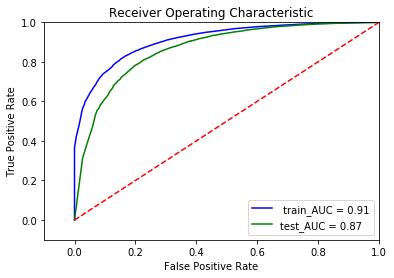

In [87]:
predict_y_train =  sig_clf_avg.predict_proba(sent_vectors)[:,1]
predict_y_test =sig_clf_avg.predict_proba(sent_vectors_test)[:,1]
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
construction of confusion matrix for test data

-------------------- Confusion matrix --------------------


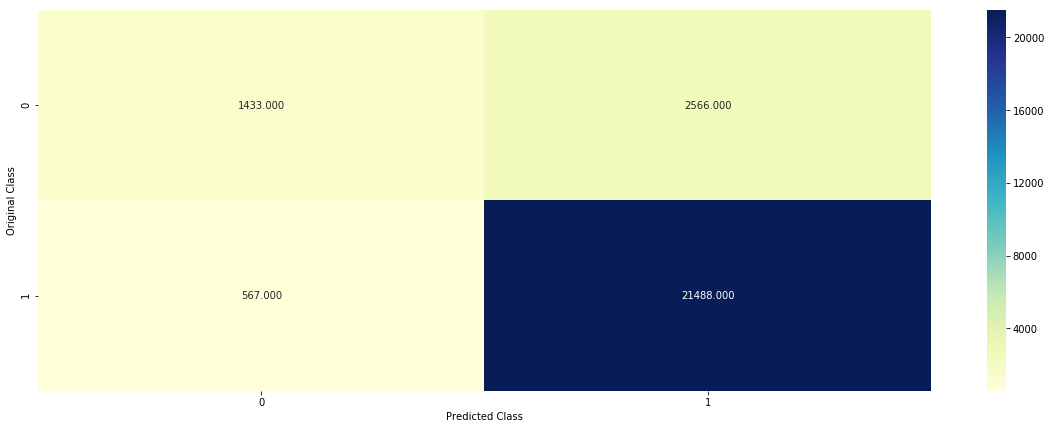

-------------------- Precision matrix (Columm Sum=1) --------------------


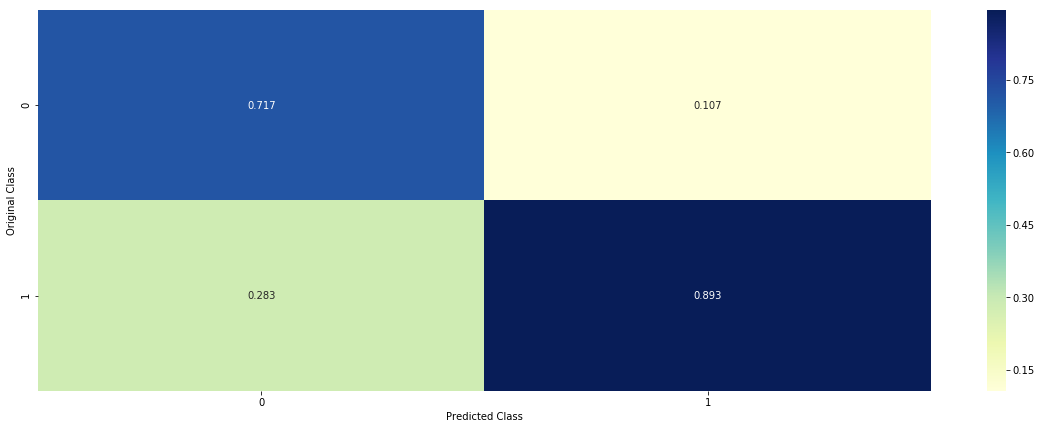

-------------------- Recall matrix (Row sum=1) --------------------


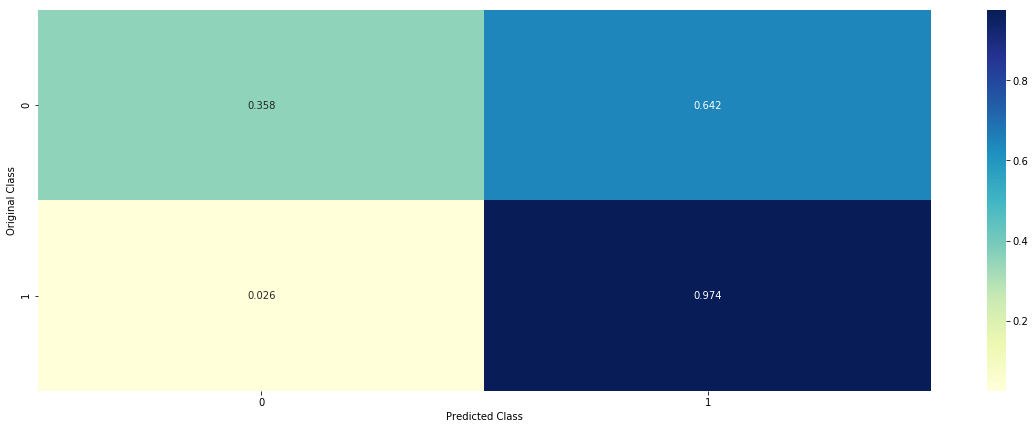

In [88]:

predict_y = sig_clf_avg.predict(sent_vectors_test)
plot_confusion_matrix(y_test, predict_y)

In [ ]:
confusion matrix for test data

-------------------- Confusion matrix --------------------


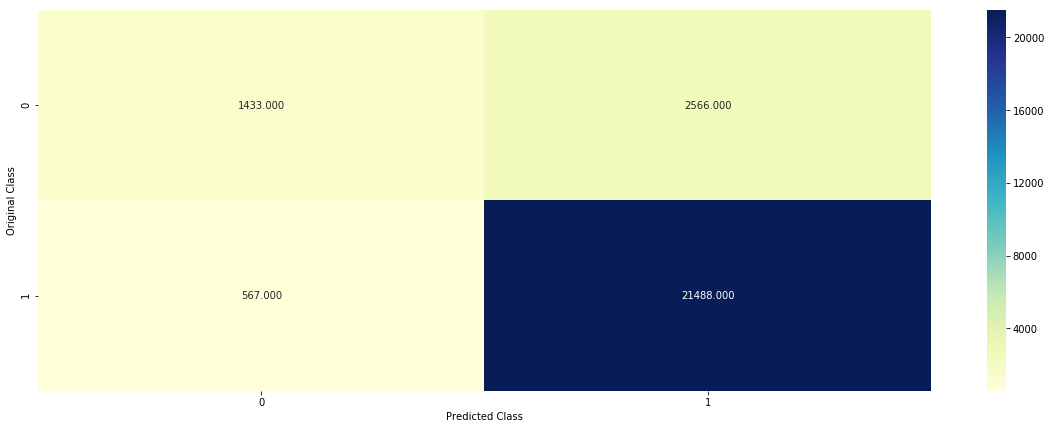

-------------------- Precision matrix (Columm Sum=1) --------------------


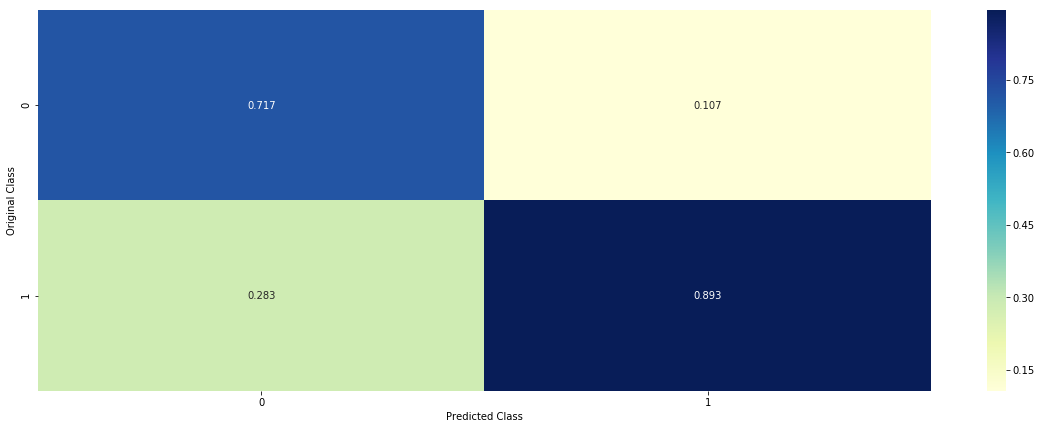

-------------------- Recall matrix (Row sum=1) --------------------


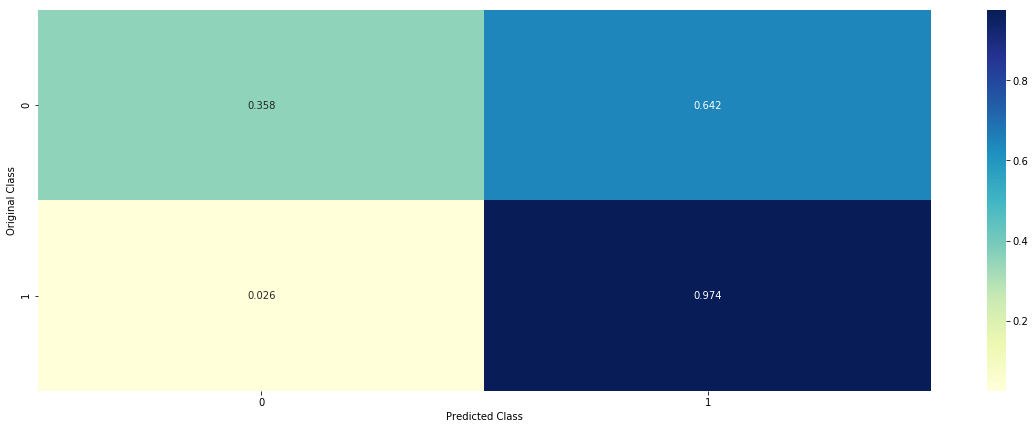

In [89]:

predict_y = sig_clf_avg.predict(sent_vectors_test)
plot_confusion_matrix(y_test, predict_y)

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

for k = 1
for k = 3
for k = 5
for k = 7
for k = 9
for k = 11
for k = 13

The optimal alpha is . 13


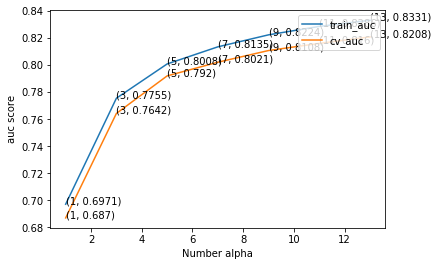

the auc score for each alpha value is :  [0.6971 0.7755 0.8008 0.8135 0.8224 0.8286 0.8331]
For values of best alpha =  13 The train auc is: 0.889288344316752
For values of best alpha =  13 The cross validation auc is: 83.616899587254
For values of best alpha =  13 The test  auc is: 83.78334268445823


In [90]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
myList = list(range(0,15))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# list that hold the cv score list
cv_scores_train=[]
cv_scores_cv=[]
# performing 10-fold cross validation using brute force approach
for k in neighbors:
    print("for k =", k)
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    knn.fit(tfidf_sent_vectors,  y_tr)
    sig_clf_word = CalibratedClassifierCV(knn, method="sigmoid")
    sig_clf_word.fit(tfidf_sent_vectors,  y_tr)
    scores_train = cross_val_score(sig_clf_word,tfidf_sent_vectors,  y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf_word, tfidf_sent_vectors_cv, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
optimal_k = neighbors[cv_scores_train.index(max(cv_scores_train))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(neighbors, cv_scores_train,label="train_auc")
plt.plot(neighbors, cv_scores_cv,label="cv_auc")


for xy in zip(neighbors, np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(neighbors, np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
best_k = optimal_k
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='brute')
knn.fit(tfidf_sent_vectors,  y_tr)
sig_clf_word = CalibratedClassifierCV(knn, method="sigmoid")
sig_clf_word.fit(tfidf_sent_vectors,  y_tr)
predict_y = sig_clf_word.predict_proba(tfidf_sent_vectors)[:,1]
acc = roc_auc_score(y_tr, predict_y)
print('For values of best alpha = ', best_k, "The train auc is:",acc)
predict_y = sig_clf_word.predict_proba(tfidf_sent_vectors_cv)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_k, "The cross validation auc is:",acc)
predict_y = sig_clf_word.predict_proba(tfidf_sent_vectors_test)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_k, "The test  auc is:",acc)

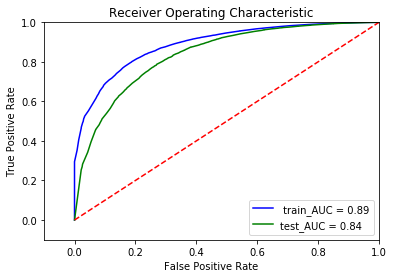

In [91]:
predict_y_train =  sig_clf_word.predict_proba(tfidf_sent_vectors)[:,1]
predict_y_test =sig_clf_word.predict_proba(tfidf_sent_vectors_test)[:,1]
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


-------------------- Confusion matrix --------------------


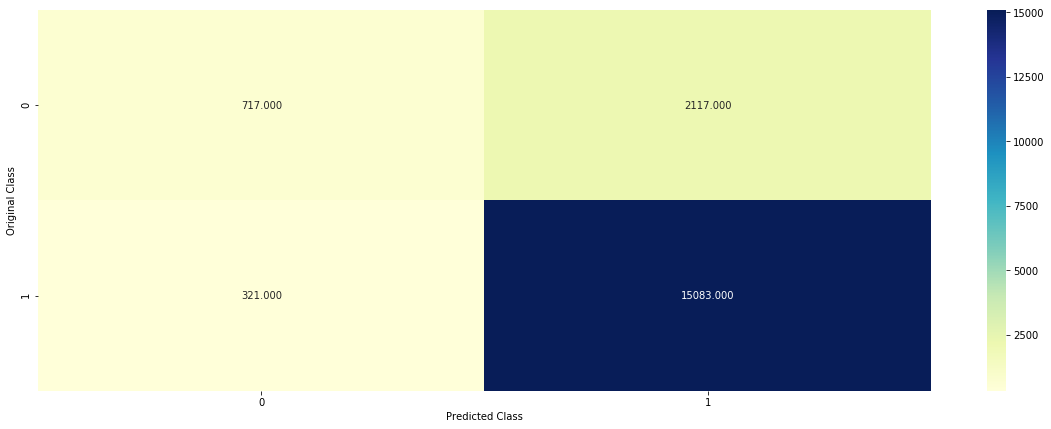

-------------------- Precision matrix (Columm Sum=1) --------------------


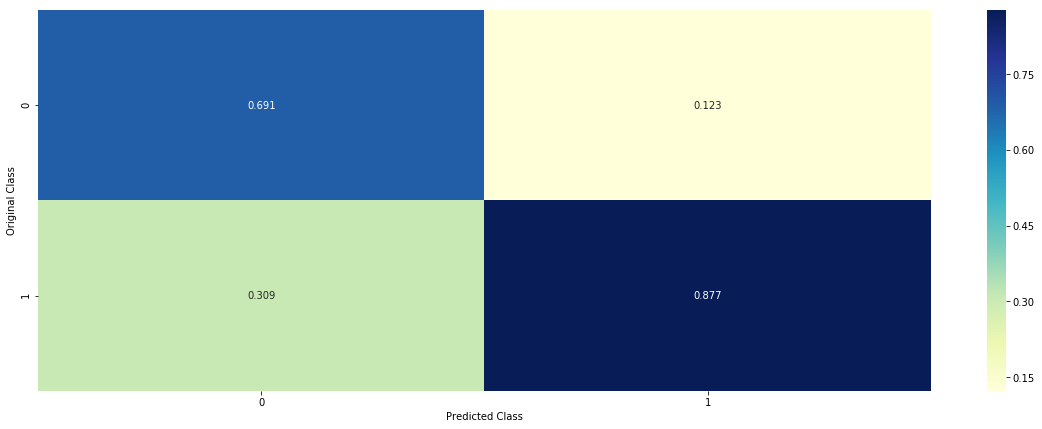

-------------------- Recall matrix (Row sum=1) --------------------


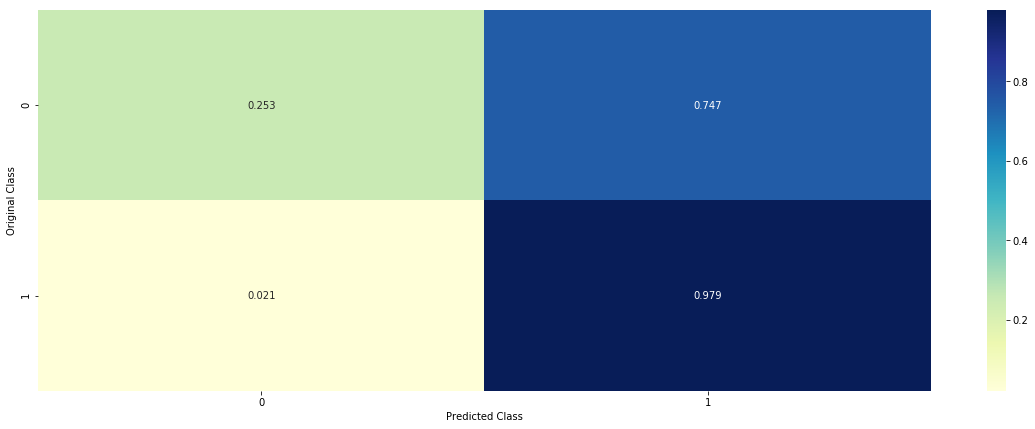

In [93]:

predict_y = sig_clf_word.predict(tfidf_sent_vectors_cv)
plot_confusion_matrix(y_cv, predict_y)

-------------------- Confusion matrix --------------------


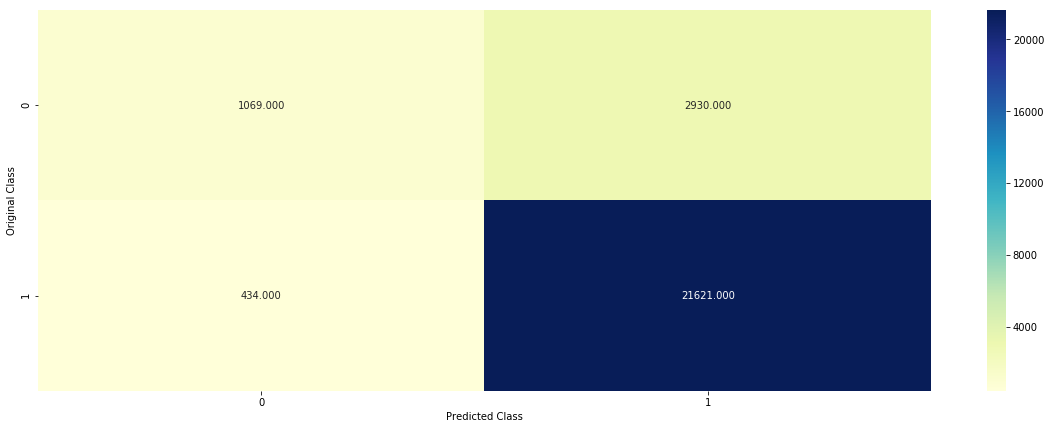

-------------------- Precision matrix (Columm Sum=1) --------------------


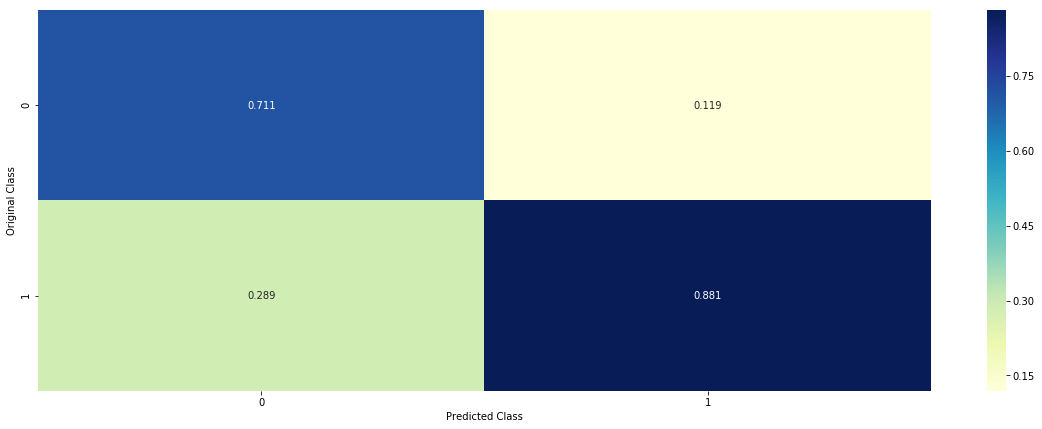

-------------------- Recall matrix (Row sum=1) --------------------


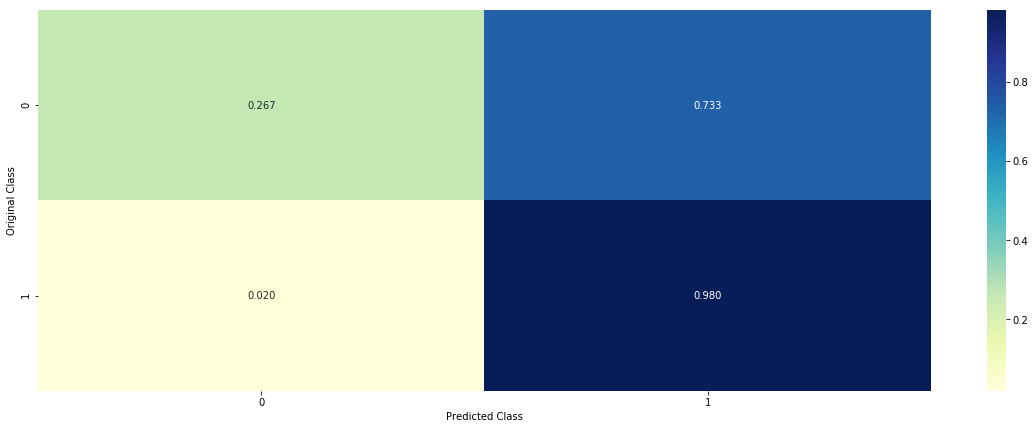

In [94]:

predict_y = sig_clf_word.predict(tfidf_sent_vectors_test)
plot_confusion_matrix(y_test, predict_y)

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

for k = 1
for k = 3
for k = 5
for k = 7
for k = 9
for k = 11
for k = 13

The optimal alpha is . 13


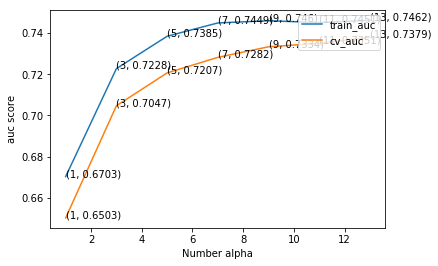

the auc score for each alpha value is :  [0.6703 0.7228 0.7385 0.7449 0.746  0.7451 0.7462]
For values of best alpha =  13 The train auc is: 0.8266183716478
For values of best alpha =  13 The cross validation auc is: 74.56984761247111
For values of best alpha =  13 The test  auc is: 75.57626597762567


In [79]:
# Please write all the code with proper documentation
from sklearn.neighbors import KDTree
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.neighbors import KDTree
myList = list(range(0,15))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# list that hold the cv score list
cv_scores_train=[]
cv_scores_cv=[]
# performing 10-fold cross validation using brute force approach
for k in neighbors:
    print("for k =", k)
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs=6)
    knn.fit(bag_counts_kdtree,y_tr)
    sig_clf_bow = CalibratedClassifierCV(knn, method="sigmoid")
    sig_clf_bow.fit(bag_counts_kdtree, y_tr)
    scores_train = cross_val_score(sig_clf_bow, bag_counts_kdtree, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf_bow, cvvalues_kdtree, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
optimal_k = neighbors[cv_scores_train.index(max(cv_scores_train))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(neighbors, cv_scores_train,label="train_auc")
plt.plot(neighbors, cv_scores_cv,label="cv_auc")


for xy in zip(neighbors, np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(neighbors, np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
best_k = optimal_k
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree')
knn.fit(bag_counts_kdtree,y_tr)
sig_clf_bow = CalibratedClassifierCV(knn, method="sigmoid")
sig_clf_bow.fit(bag_counts_kdtree, y_tr)
predict_y = sig_clf_bow.predict_proba(bag_counts_kdtree)[:,1]
acc = roc_auc_score(y_tr, predict_y)
print('For values of best alpha = ', best_k, "The train auc is:",acc)
predict_y = sig_clf_bow.predict_proba(cvvalues_kdtree)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_k, "The cross validation auc is:",acc)
predict_y = sig_clf_bow.predict_proba(testvalues_kdtree)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_k, "The test  auc is:",acc)

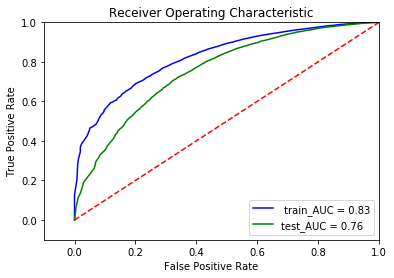

In [80]:

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

predict_y_train = sig_clf_bow.predict_proba(bag_counts_kdtree)[:,1]
predict_y_test = sig_clf_bow.predict_proba(testvalues_kdtree)[:,1]
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()








-------------------- Confusion matrix --------------------


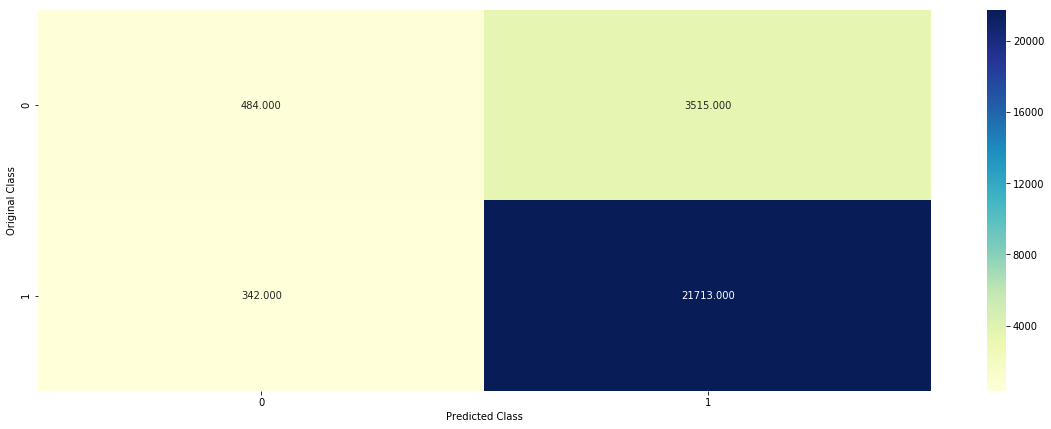

-------------------- Precision matrix (Columm Sum=1) --------------------


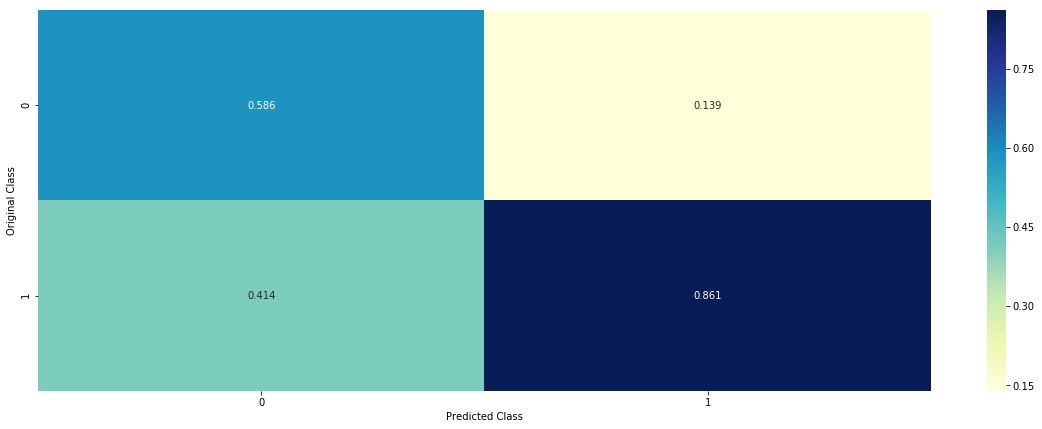

-------------------- Recall matrix (Row sum=1) --------------------


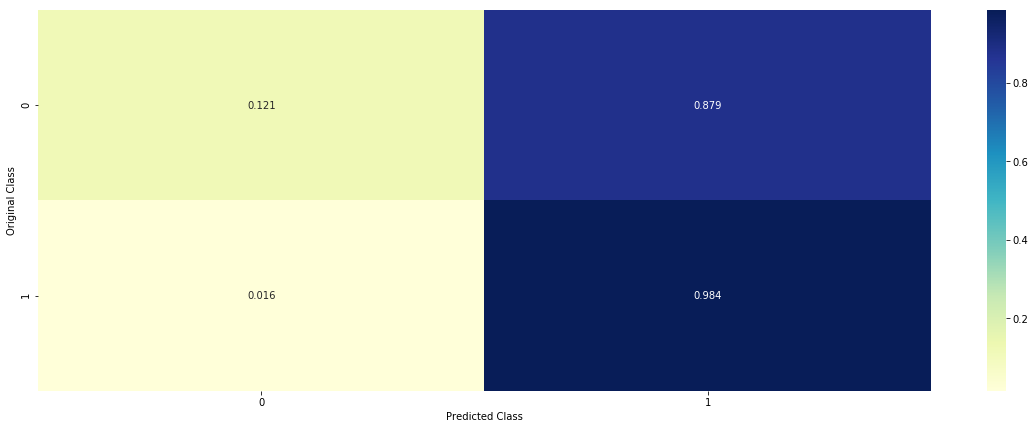

In [81]:
predict_y = sig_clf_bow.predict(testvalues_kdtree)
plot_confusion_matrix(y_test, predict_y)

-------------------- Confusion matrix --------------------


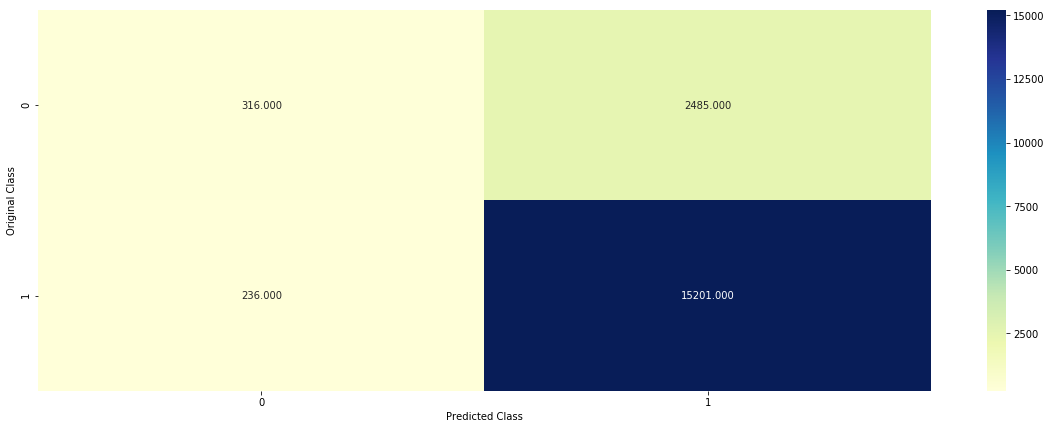

-------------------- Precision matrix (Columm Sum=1) --------------------


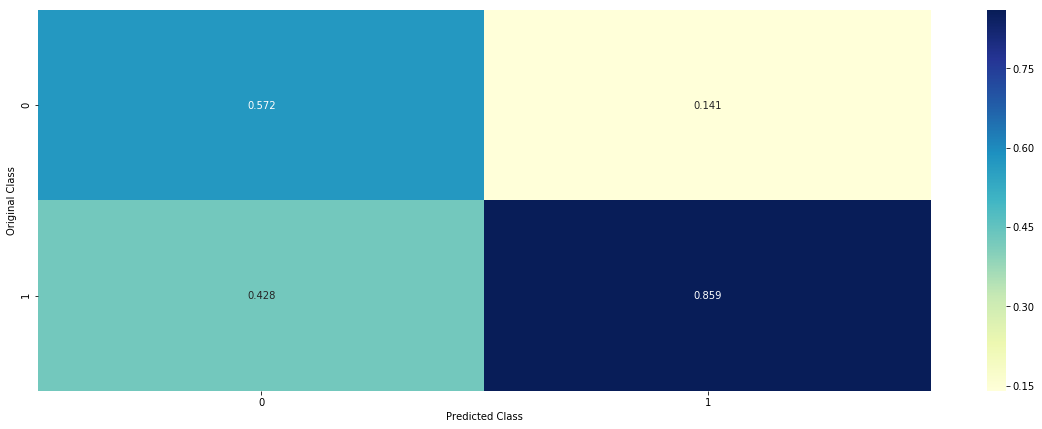

-------------------- Recall matrix (Row sum=1) --------------------


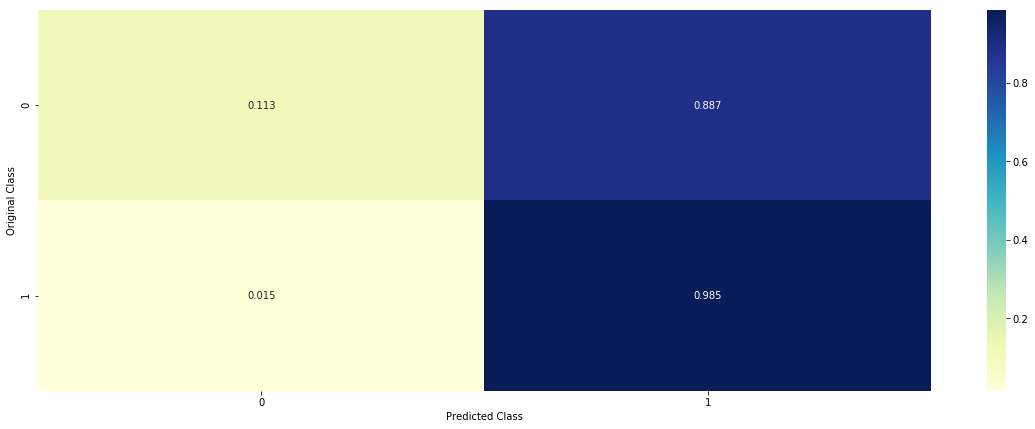

In [82]:
predict_y = sig_clf_bow.predict(cvvalues_kdtree)
plot_confusion_matrix(y_cv, predict_y)

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

for k = 1
for k = 3
for k = 5
for k = 7
for k = 9
for k = 11
for k = 13

The optimal alpha is . 5


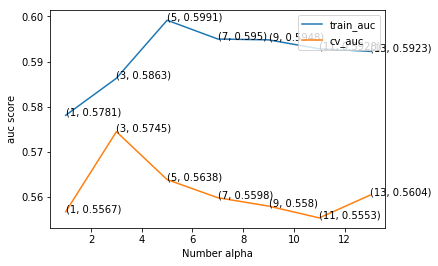

the auc score for each alpha value is :  [0.5781 0.5863 0.5991 0.595  0.5948 0.5928 0.5923]
For values of best alpha =  5 The train auc is: 0.8764914297559593
For values of best alpha =  5 The cross validation auc is: 61.130658390935025
For values of best alpha =  5 The test  auc is: 60.1795506686692


In [83]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
myList = list(range(0,15))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# list that hold the cv score list
cv_scores_train=[]
cv_scores_cv=[]
# performing 10-fold cross validation using brute force approach
for k in neighbors:
    print("for k =", k)
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute', n_jobs=6)
    knn.fit(train_tfidf_text_kdtree, y_tr)
    sig_clf_tfidf = CalibratedClassifierCV(knn, method="sigmoid")
    sig_clf_tfidf.fit(train_tfidf_text_kdtree, y_tr)
    scores_train = cross_val_score(sig_clf_tfidf,train_tfidf_text_kdtree, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf_tfidf, cv_tfidf_text_kdtree, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
optimal_k = neighbors[cv_scores_train.index(max(cv_scores_train))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(neighbors, cv_scores_train,label="train_auc")
plt.plot(neighbors, cv_scores_cv,label="cv_auc")


for xy in zip(neighbors, np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(neighbors, np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
best_k = optimal_k
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree')
knn.fit(train_tfidf_text_kdtree, y_tr)
sig_clf_tfidf = CalibratedClassifierCV(knn, method="sigmoid")
sig_clf_tfidf.fit(train_tfidf_text_kdtree, y_tr)
predict_y = sig_clf_tfidf.predict_proba(train_tfidf_text_kdtree)[:,1]
acc = roc_auc_score(y_tr, predict_y)
print('For values of best alpha = ', best_k, "The train auc is:",acc)
predict_y = sig_clf_tfidf.predict_proba(cv_tfidf_text_kdtree)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_k, "The cross validation auc is:",acc)
predict_y = sig_clf_tfidf.predict_proba(test_tfidf_text_kdtree)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_k, "The test  auc is:",acc)

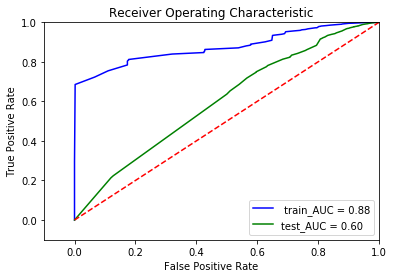

In [84]:
predict_y_train = sig_clf_tfidf.predict_proba(train_tfidf_text_kdtree)[:,1]
predict_y_test = sig_clf_tfidf.predict_proba(test_tfidf_text_kdtree)[:,1]
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()





-------------------- Confusion matrix --------------------


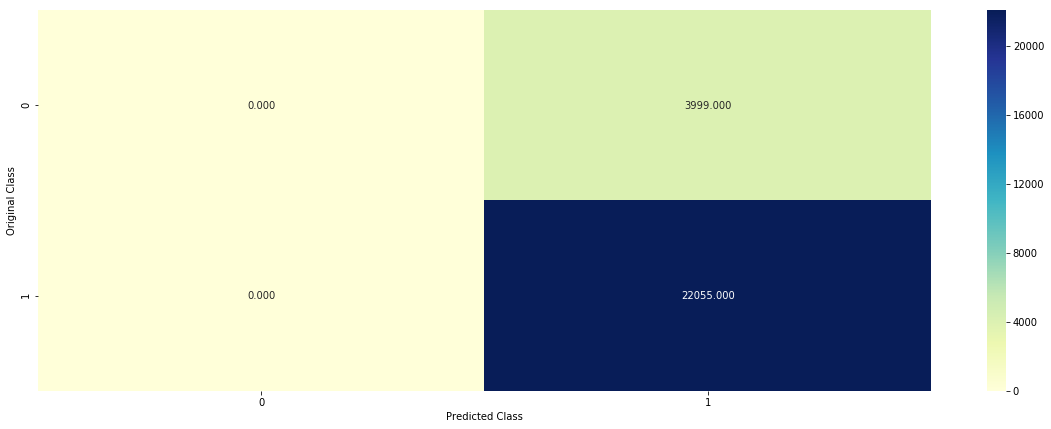

-------------------- Precision matrix (Columm Sum=1) --------------------


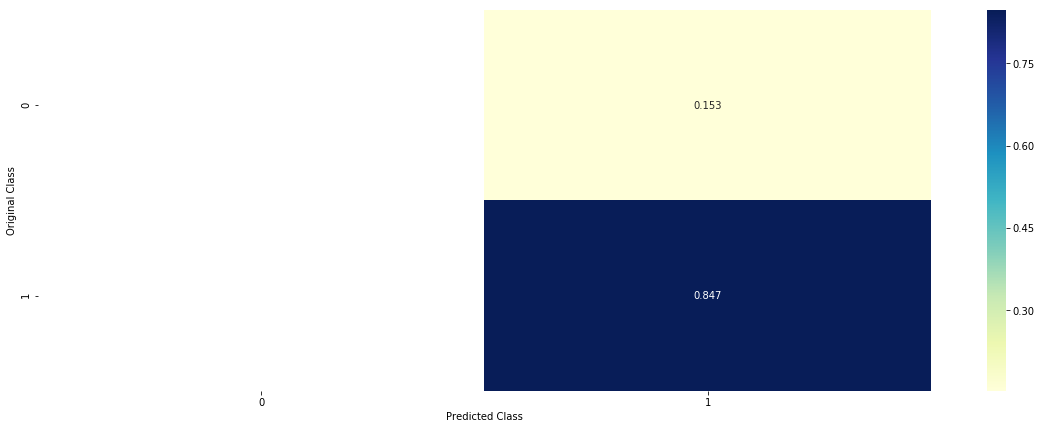

-------------------- Recall matrix (Row sum=1) --------------------


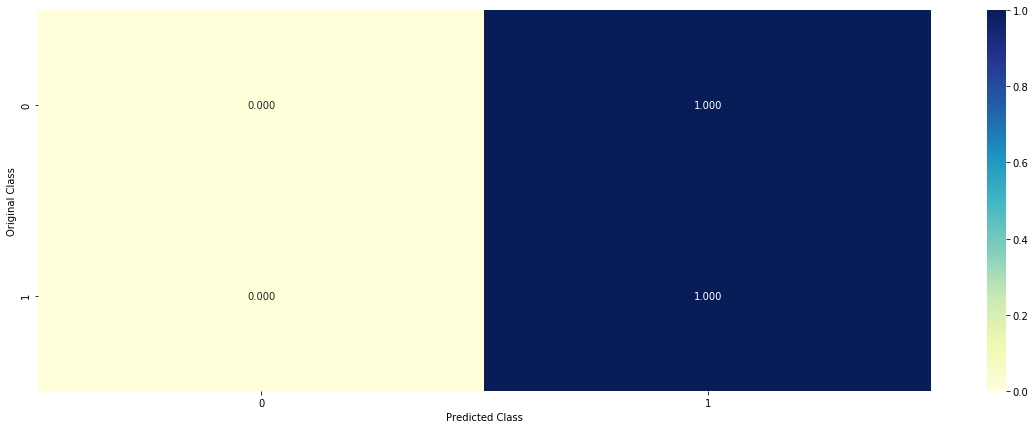

In [85]:
predict_y = sig_clf_tfidf.predict(test_tfidf_text_kdtree)
plot_confusion_matrix(y_test, predict_y)


-------------------- Confusion matrix --------------------


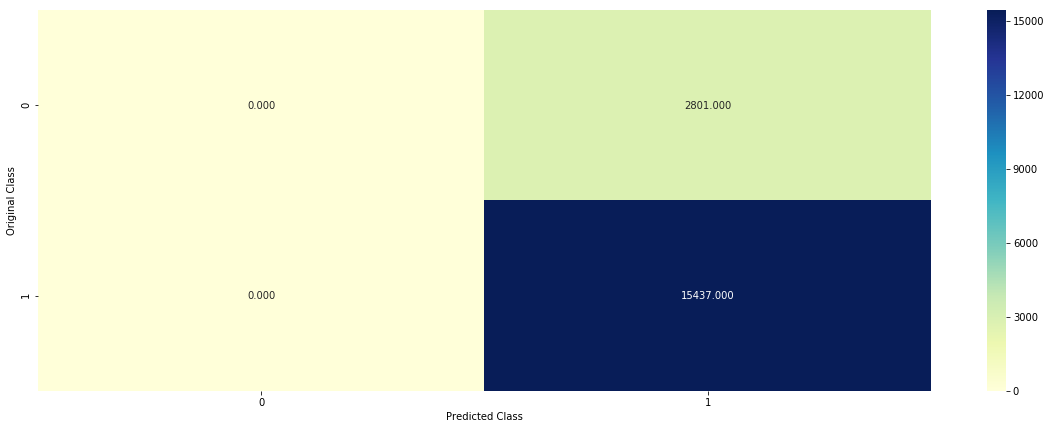

-------------------- Precision matrix (Columm Sum=1) --------------------


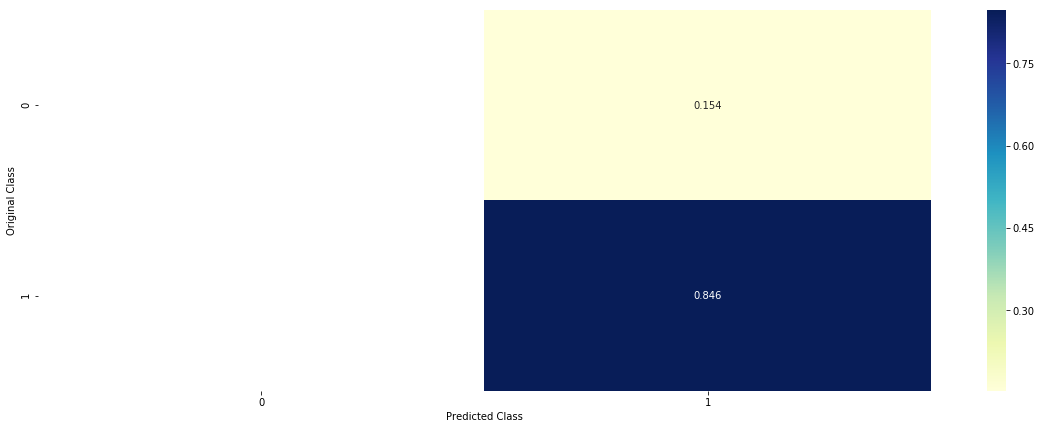

-------------------- Recall matrix (Row sum=1) --------------------


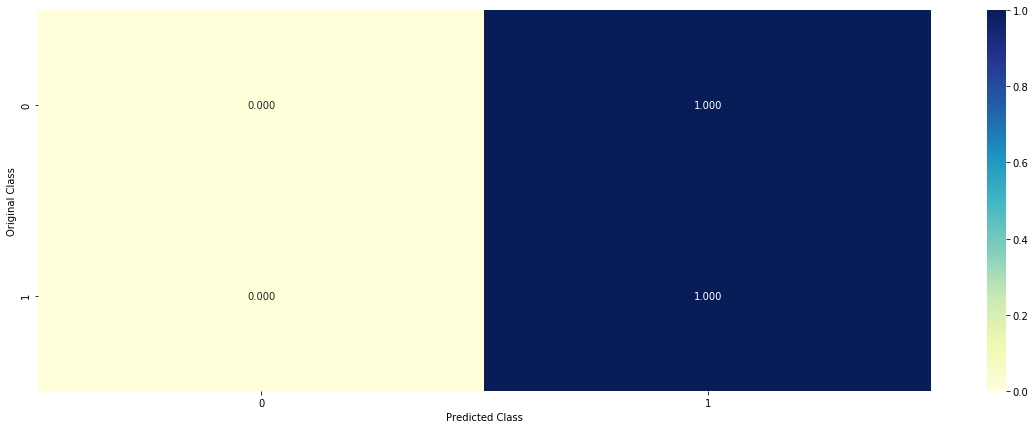

In [86]:
predict_y = sig_clf_tfidf.predict(cv_tfidf_text_kdtree)
plot_confusion_matrix(y_cv, predict_y)

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

for k = 1
for k = 3
for k = 5
for k = 7
for k = 9
for k = 11
for k = 13

The optimal alpha is . 13


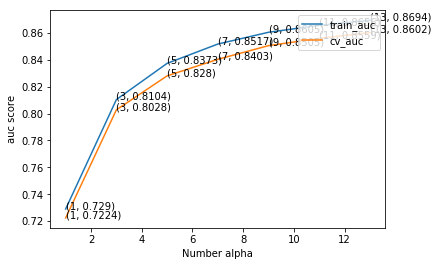

the auc score for each alpha value is :  [0.729  0.8104 0.8373 0.8517 0.8605 0.8656 0.8694]
For values of best alpha =  13 The train auc is: 0.9128453742611233
For values of best alpha =  13 The cross validation auc is: 86.87316856756084
For values of best alpha =  13 The test  auc is: 86.7739673526407


In [87]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
myList = list(range(0,15))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# list that hold the cv score list
cv_scores_train=[]
cv_scores_cv=[]
# performing 10-fold cross validation using brute force approach
for k in neighbors:
    print("for k =", k)
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree' ,n_jobs=6)
    knn.fit(sent_vectors,  y_tr)
    sig_clf_avg = CalibratedClassifierCV(knn, method="sigmoid")
    sig_clf_avg.fit(sent_vectors,  y_tr)
    scores_train = cross_val_score(sig_clf_avg,sent_vectors,  y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf_avg, sent_vectors_cv, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
optimal_k = neighbors[cv_scores_train.index(max(cv_scores_train))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(neighbors, cv_scores_train,label="train_auc")
plt.plot(neighbors, cv_scores_cv,label="cv_auc")


for xy in zip(neighbors, np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(neighbors, np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
best_k = optimal_k
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree')
knn.fit(sent_vectors,  y_tr)
sig_clf_avg = CalibratedClassifierCV(knn, method="sigmoid")
sig_clf_avg.fit(sent_vectors,  y_tr)
predict_y = sig_clf_avg.predict_proba(sent_vectors)[:,1]
acc = roc_auc_score(y_tr, predict_y)
print('For values of best alpha = ', best_k, "The train auc is:",acc)
predict_y = sig_clf_avg.predict_proba(sent_vectors_cv)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_k, "The cross validation auc is:",acc)
predict_y = sig_clf_avg.predict_proba(sent_vectors_test)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_k, "The test  auc is:",acc)

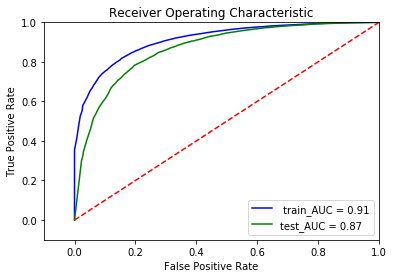

In [88]:
predict_y_train =  sig_clf_avg.predict_proba(sent_vectors)[:,1]
predict_y_test =sig_clf_avg.predict_proba(sent_vectors_test)[:,1]
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()






-------------------- Confusion matrix --------------------


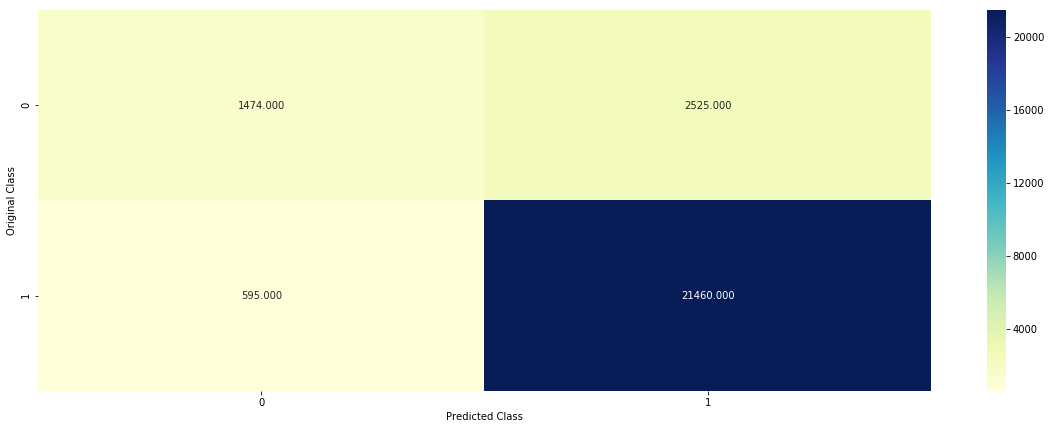

-------------------- Precision matrix (Columm Sum=1) --------------------


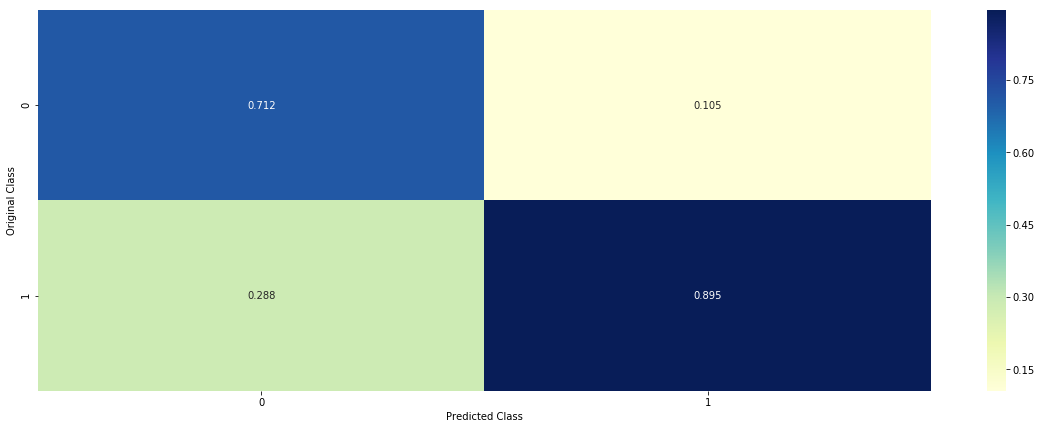

-------------------- Recall matrix (Row sum=1) --------------------


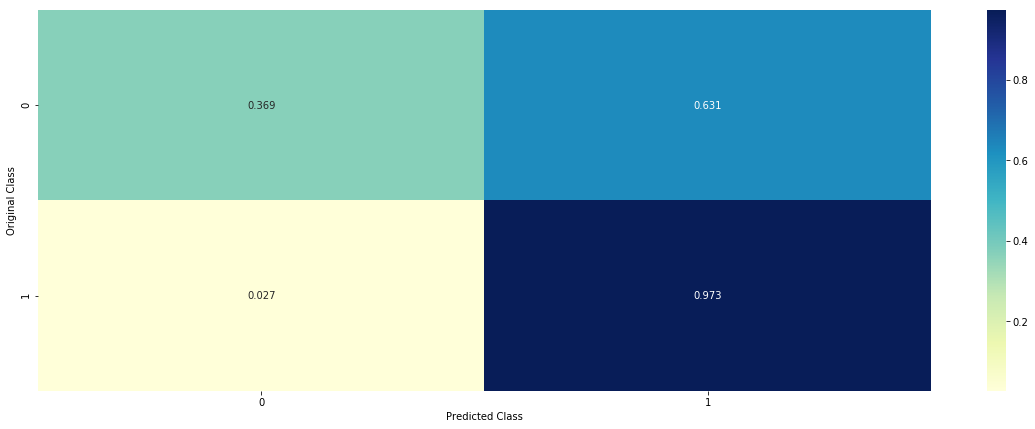

In [89]:
predict_y = sig_clf_avg.predict(sent_vectors_test)
plot_confusion_matrix(y_test, predict_y)

-------------------- Confusion matrix --------------------


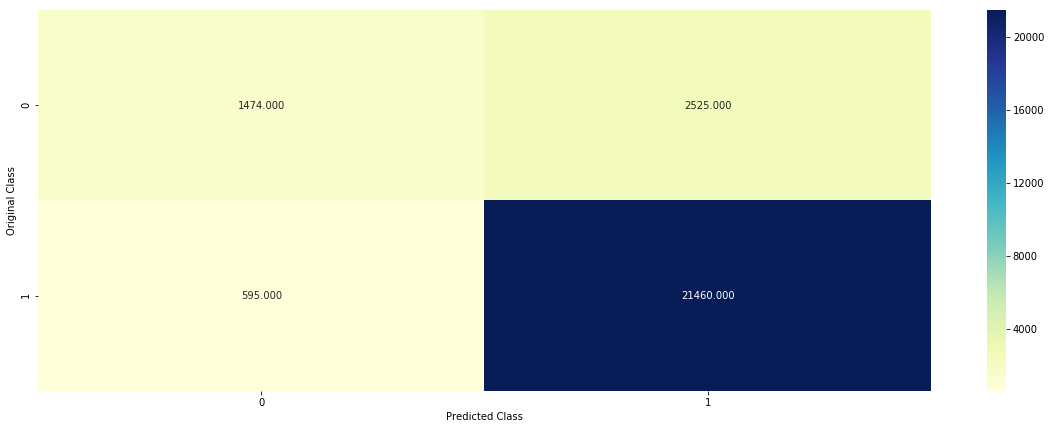

-------------------- Precision matrix (Columm Sum=1) --------------------


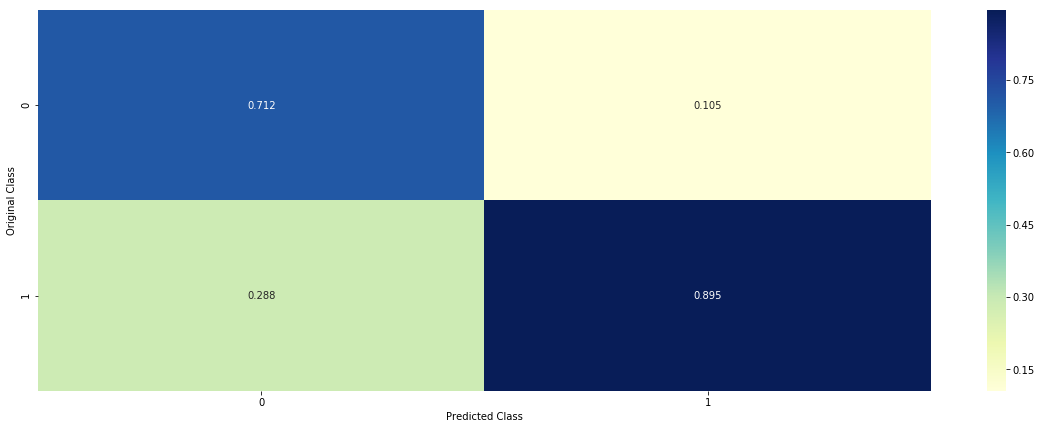

-------------------- Recall matrix (Row sum=1) --------------------


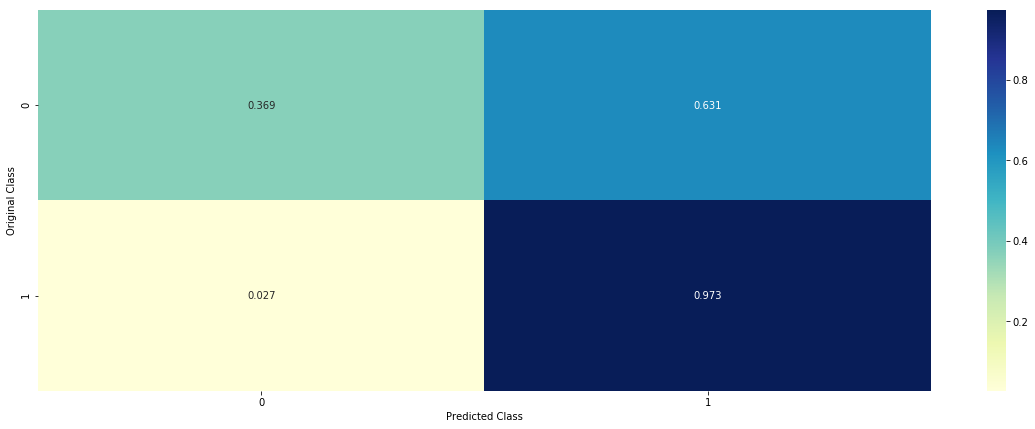

In [90]:

predict_y = sig_clf_avg.predict(sent_vectors_test)
plot_confusion_matrix(y_test, predict_y)

-------------------- Confusion matrix --------------------


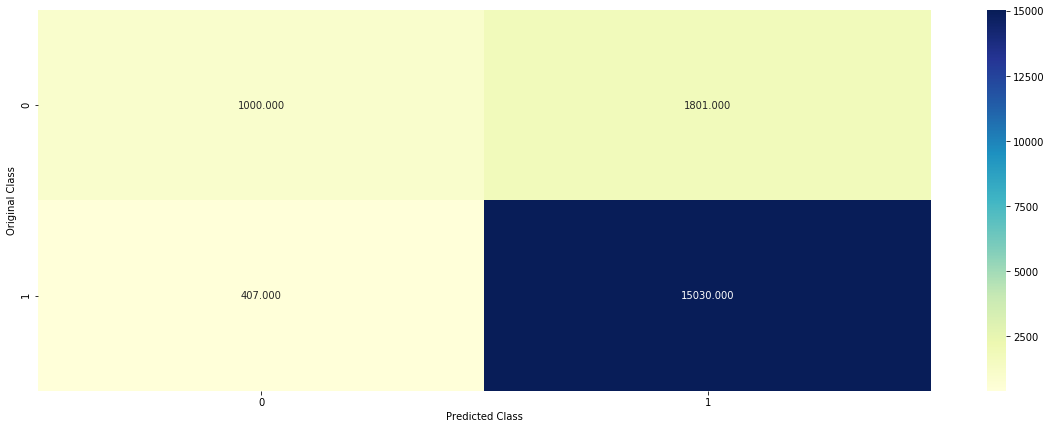

-------------------- Precision matrix (Columm Sum=1) --------------------


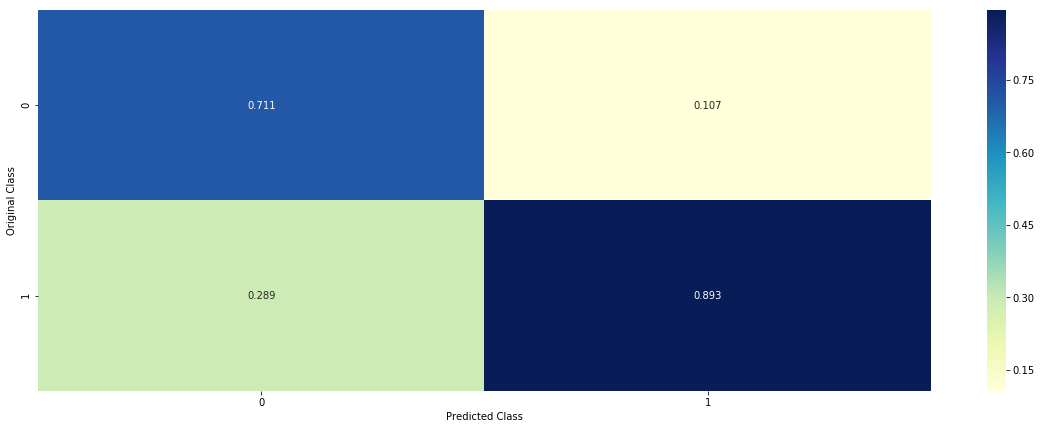

-------------------- Recall matrix (Row sum=1) --------------------


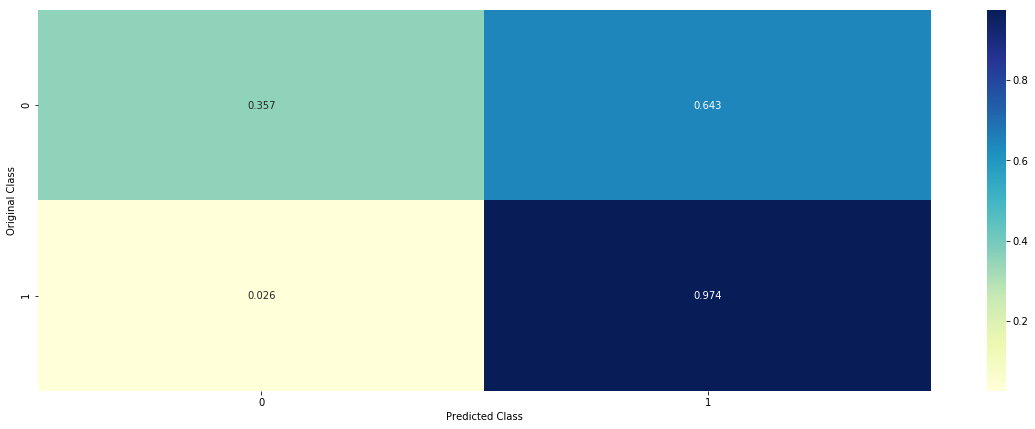

In [91]:

predict_y = sig_clf_avg.predict(sent_vectors_cv)
plot_confusion_matrix(y_cv, predict_y)

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

for k = 1
for k = 3
for k = 5
for k = 7
for k = 9
for k = 11
for k = 13

The optimal alpha is . 13


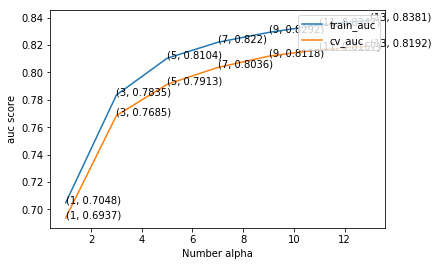

the auc score for each alpha value is :  [0.7048 0.7835 0.8104 0.822  0.8292 0.8347 0.8381]
For values of best alpha =  13 The train auc is: 0.8914920313052235
For values of best alpha =  13 The cross validation auc is: 82.74967016494838
For values of best alpha =  13 The test  auc is: 83.22814777600543


In [92]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
myList = list(range(0,15))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# list that hold the cv score list
cv_scores_train=[]
cv_scores_cv=[]
# performing 10-fold cross validation using brute force approach
for k in neighbors:
    print("for k =", k)
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree', n_jobs=4)
    knn.fit(tfidf_sent_vectors,  y_tr)
    sig_clf_word = CalibratedClassifierCV(knn, method="sigmoid")
    sig_clf_word.fit(tfidf_sent_vectors,  y_tr)
    scores_train = cross_val_score(sig_clf_word,tfidf_sent_vectors,  y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf_word, tfidf_sent_vectors_cv, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
optimal_k = neighbors[cv_scores_train.index(max(cv_scores_train))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(neighbors, cv_scores_train,label="train_auc")
plt.plot(neighbors, cv_scores_cv,label="cv_auc")


for xy in zip(neighbors, np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(neighbors, np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()


print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
best_k = optimal_k
knn = KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree')
knn.fit(tfidf_sent_vectors,  y_tr)
sig_clf_word = CalibratedClassifierCV(knn, method="sigmoid")
sig_clf_word.fit(tfidf_sent_vectors,  y_tr)
predict_y = sig_clf_word.predict_proba(tfidf_sent_vectors)[:,1]
acc = roc_auc_score(y_tr, predict_y)
print('For values of best alpha = ', best_k, "The train auc is:",acc)
predict_y = sig_clf_word.predict_proba(tfidf_sent_vectors_cv)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_k, "The cross validation auc is:",acc)
predict_y = sig_clf_word.predict_proba(tfidf_sent_vectors_test)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_k, "The test  auc is:",acc)

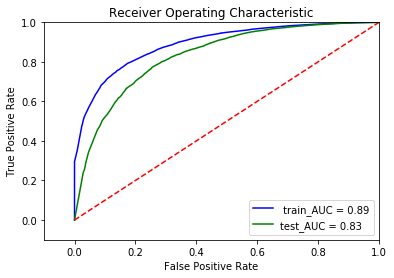

In [93]:
predict_y_train =  sig_clf_word.predict_proba(tfidf_sent_vectors)[:,1]
predict_y_test =sig_clf_word.predict_proba(tfidf_sent_vectors_test)[:,1]
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()







-------------------- Confusion matrix --------------------


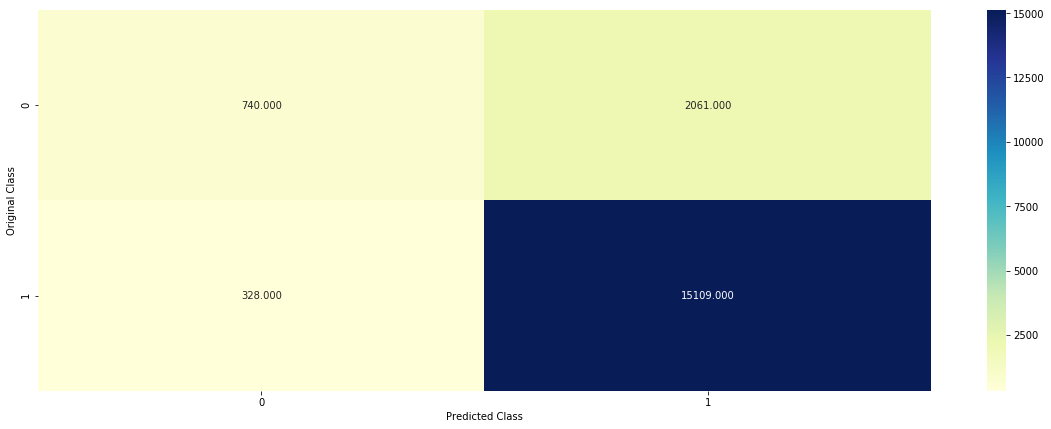

-------------------- Precision matrix (Columm Sum=1) --------------------


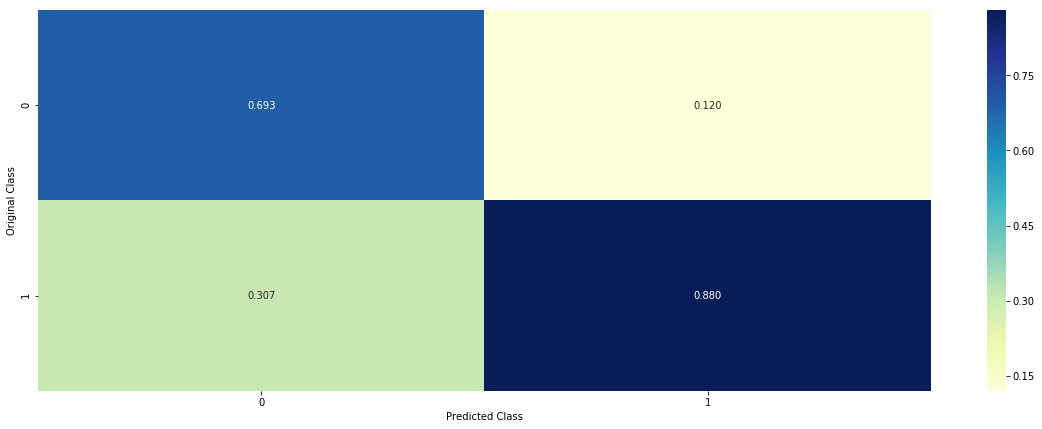

-------------------- Recall matrix (Row sum=1) --------------------


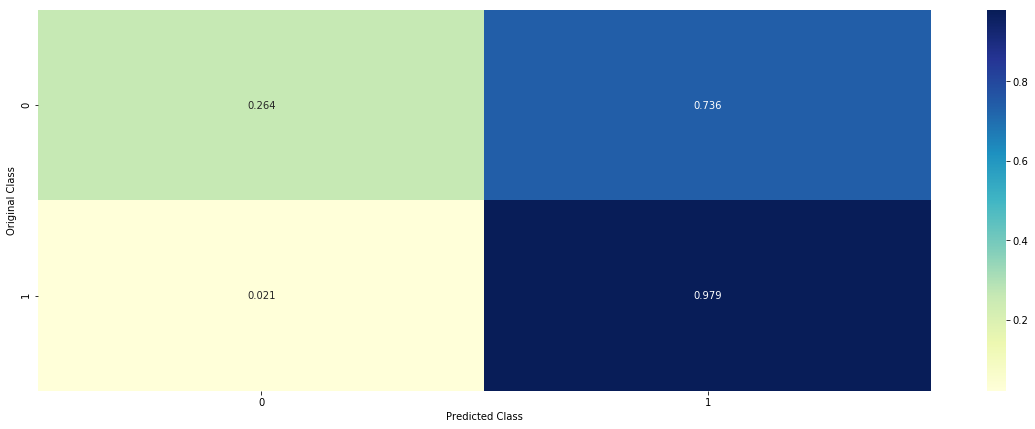

In [94]:
predict_y = sig_clf_word.predict(tfidf_sent_vectors_cv)
plot_confusion_matrix(y_cv, predict_y)

-------------------- Confusion matrix --------------------


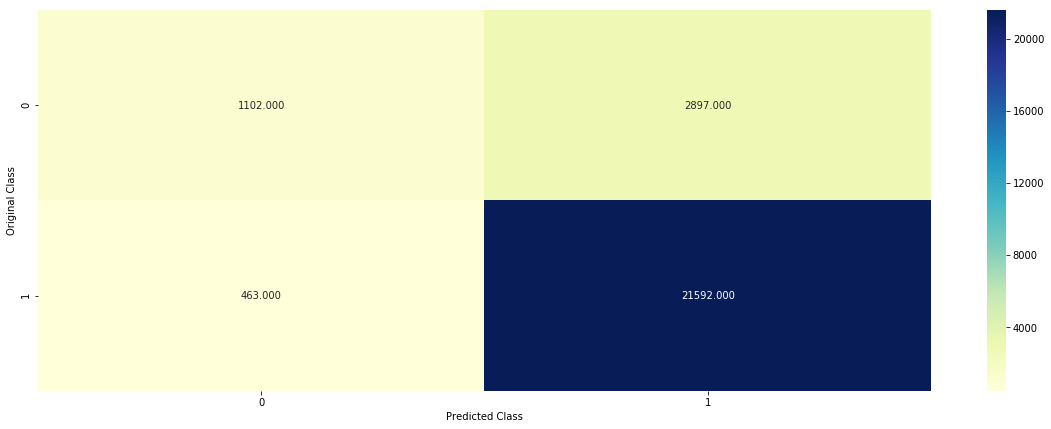

-------------------- Precision matrix (Columm Sum=1) --------------------


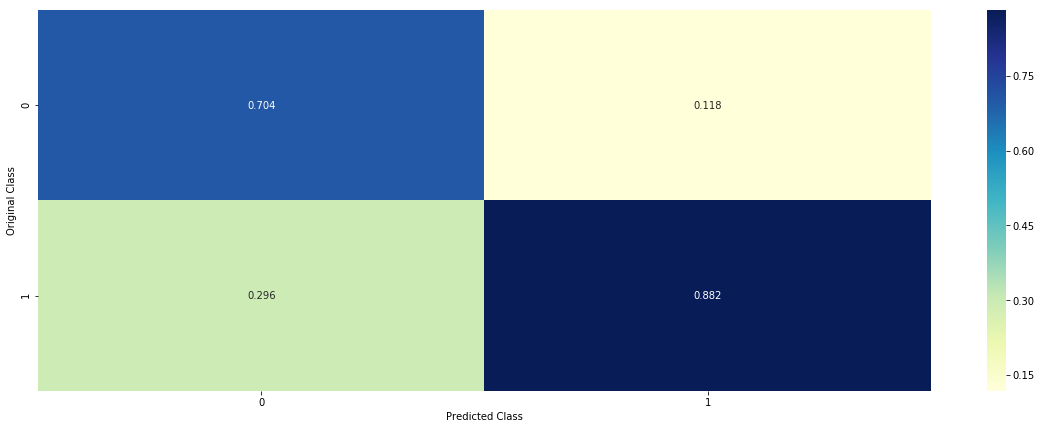

-------------------- Recall matrix (Row sum=1) --------------------


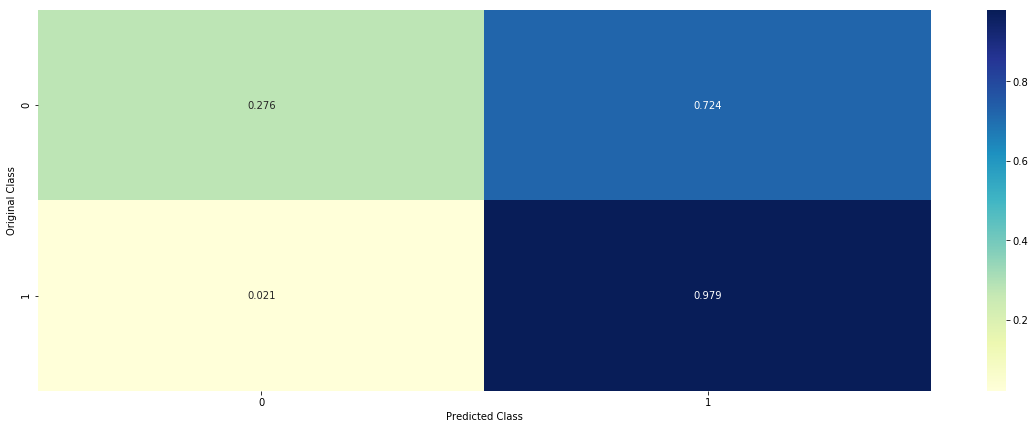

In [95]:
predict_y = sig_clf_word.predict(tfidf_sent_vectors_test)
plot_confusion_matrix(y_test, predict_y)

# [6] Conclusions

In [2]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "best K", "AUC_train","AUC_CV","AUC_test"]
x.add_row(["BOW", "Brute Force",9 ,83.58166403385319, 69.57398929642228,69.26057517553272])
x.add_row(["TF-IDF", "Brute Force", 3, 99.43531076722377,50.93215232293549,50.69323213823179])
x.add_row(["AVG-word 2vec", "Brute Force", 13,91.25499005528506,87.08075187648883,86.65615508388545])
x.add_row([" TFIDF W2v", "Brute Force", 13,88.9288344316752,83.616899587254, 83.78334268445823])

x.add_row(["BOW", "kd-tree",13 ,82.66183716478,74.56984761247111, 75.57626597762567])
x.add_row(["TF-IDF", "kd-tree", 5, 87.64914297559593,61.130658390935025, 60.1795506686692])
x.add_row(["AVG-word 2vec", "kd-tree", 13,91.28453742611233,86.87316856756084,86.7739673526407])
x.add_row([" TFIDF W2v", "kd-tree", 13,89.14920313052235,82.74967016494838,83.22814777600543])

print(x)


+---------------+-------------+--------+-------------------+--------------------+-------------------+
|   Vectorizer  |    Model    | best K |     AUC_train     |       AUC_CV       |      AUC_test     |
+---------------+-------------+--------+-------------------+--------------------+-------------------+
|      BOW      | Brute Force |   9    | 83.58166403385319 | 69.57398929642228  | 69.26057517553272 |
|     TF-IDF    | Brute Force |   3    | 99.43531076722377 | 50.93215232293549  | 50.69323213823179 |
| AVG-word 2vec | Brute Force |   13   | 91.25499005528506 | 87.08075187648883  | 86.65615508388545 |
|    TFIDF W2v  | Brute Force |   13   |  88.9288344316752 |  83.616899587254   | 83.78334268445823 |
|      BOW      |   kd-tree   |   13   |   82.66183716478  | 74.56984761247111  | 75.57626597762567 |
|     TF-IDF    |   kd-tree   |   5    | 87.64914297559594 | 61.130658390935025 |  60.1795506686692 |
| AVG-word 2vec |   kd-tree   |   13   | 91.28453742611234 | 86.87316856756084  | 